In [1]:
import os
import glob
import itertools
import json
import importlib
import cv2

import matplotlib as mpl
import scipy.stats as spstats
import dill as pkl
import pandas as pd
import numpy as np
import seaborn as sns
import pylab as pl
import statsmodels.api as sm
import tifffile as tf

In [2]:
import analyze2p.plotting as pplot
import analyze2p.receptive_fields.utils as rfutils
import analyze2p.gratings.utils as gutils
import analyze2p.extraction.rois as roiutils
import analyze2p.retinotopy.utils as retutils
import analyze2p.utils as hutils
import analyze2p.aggregate_datasets as aggr

import analyze2p.correlations as cr
import analyze2p.objects.sim_utils as su

/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.10, the latest is 0.4.0.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [3]:
%matplotlib notebook

# Plotting

In [4]:
#### Plotting params
visual_areas, area_colors = pplot.set_threecolor_palette()
pplot.set_plot_params(labelsize=6, lw_axes=0.25)
# src dirs
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'
rootdir='/n/coxfs01/2p-data'
traceid = 'traces001'


# Source

In [5]:
responsive_test='ROC'
# -----------------------------
response_type='dff'
responsive_thr=0.05 if responsive_test=='ROC' else 10.0
n_bootstrap_iters=500
print(responsive_test, responsive_thr)

ori_fit_desc = gutils.get_fit_desc(response_type=response_type, responsive_test=responsive_test, 
                            responsive_thr=responsive_thr, 
                            n_bootstrap_iters=n_bootstrap_iters)
data_id = '|'.join([traceid, ori_fit_desc])
print(data_id)

ROC 0.05
traces001|fit-dff_responsive-ROC-thr0.05_boot-500


# Aggregate meta 

In [6]:
sdata, cells0 = aggr.get_aggregate_info(visual_areas=visual_areas, return_cells=True)
meta = sdata[sdata.experiment.isin(['gratings'])].copy()

all_dkeys = [(va, dk) for (va, dk), g in meta.groupby(['visual_area', 'datakey'])]
CELLS = pd.concat([g for (va, dk), g in cells0.groupby(['visual_area', 'datakey'])\
                                  if (va, dk) in all_dkeys])
CELLS[['visual_area', 'animalid', 'session', 'fovnum']]\
            .drop_duplicates().groupby(['visual_area']).count()

/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 12 dsets


animalid  session  fovnum
visual_area                           
Li                 15       15      15
Lm                  9        9       9
V1                  9        9       9

# Output dir

In [47]:
# dst_dir = os.path.join(aggregate_dir, 'gratings-tuning', 
#                        '%s-%s' % (traceid, ori_fit_desc))
dst_dir = os.path.join(aggregate_dir, 'correlations', 
                       'gratings_%s_%s' % (response_type, responsive_test),
                       'pref_theta')
examples_dir = os.path.join(dst_dir, 'examples')
if not os.path.exists(examples_dir):
    os.makedirs(examples_dir)
print(examples_dir)

print(dst_dir)

FIGDIR = os.path.join(aggregate_dir, 'FIGURES')
print(FIGDIR)

/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/gratings_dff_ROC/pref_theta/examples
/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/gratings_dff_ROC/pref_theta
/n/coxfs01/julianarhee/aggregate-visual-areas/FIGURES


# All fits

In [8]:
gdata, missing_ = gutils.aggregate_ori_fits(CELLS, traceid=traceid, create_new=False,
                            fit_desc=ori_fit_desc, return_missing=True) 
gdata = hutils.split_datakey(gdata)
gdata['tf'] = gdata['sf']*gdata['speed'] # fit params
# Assign "preferred theta" for tested values
tested_thetas = np.arange(0, 360, 45)
theta_vals = np.arange(0, 360+45, 45)
gdata['tested_theta'] = [theta_vals[np.where(np.abs(t-theta_vals)==np.min(np.abs(t-theta_vals)))[0][0]] % 360. \
                            for t in gdata['theta_pref']]
gdata['tested_theta'] = gdata['tested_theta'].astype(dst_difloat)
# Best GoF condition for each cell
best_gof_ixs = gdata.groupby(['visual_area', 'datakey', 'cell'])['gof']\
                    .transform(max) == gdata['gof']
assert gdata.loc[best_gof_ixs].groupby(['visual_area', 'datakey', 'cell'])\
                    .count().max().max()==1
bestg = gdata.loc[best_gof_ixs].copy()
bestg['experiment'] = 'gratings'

In [9]:
missing_

['Li_20190319_JC067_fov1']

#### Filter fits

In [10]:
# Unique datasets, get dsets with most ncells pass
min_ncells=0
gof_thr=0.5
drop_repeats=True
# ----------------------------------------
counts = aggr.count_n_cells(bestg[bestg['gof']>gof_thr], 
                            name='n_cells', reset_index=True)
print("All cells pass (GoF>%.2f)" % gof_thr)
print(counts.groupby('visual_area').sum().to_markdown())
# Drop duplicates
u_dkeys = aggr.drop_repeats(counts, colname='n_cells')   
FITS = pd.concat([g for (va, dk), g in bestg[bestg['gof']>gof_thr].groupby(['visual_area', 'datakey'])\
          if (va, dk) in u_dkeys])
ncells_fit = aggr.count_n_cells(FITS)
print("Unique datasets (pass, GoF>%.2f)" % gof_thr)
print(ncells_fit.groupby('visual_area').sum().to_markdown())

All cells pass (GoF>0.50)
| visual_area   |   n_cells |
|:--------------|----------:|
| Li            |        90 |
| Lm            |       222 |
| V1            |       444 |
Unique datasets (pass, GoF>0.50)
| visual_area   |   n_cells |
|:--------------|----------:|
| Li            |        62 |
| Lm            |       214 |
| V1            |       444 |


# All data

In [11]:
trial_epoch='stimulus'
experiment='gratings'
NDATA0 = aggr.get_aggregate_data(experiment, traceid=traceid, 
                      response_type=response_type, epoch=trial_epoch,
                      responsive_test=responsive_test, 
                      responsive_thr=responsive_thr)
# Drop same duplicates from trial responses
NDATA = pd.concat([g for (va, dk), g \
                   in NDATA0.groupby(['visual_area', 'datakey'])\
                   if (va, dk) in u_dkeys], ignore_index=True)
if 'experiment' not in NDATA.columns:
    NDATA['experiment'] = experiment
# Final counts
final_ncells = aggr.count_n_cells(NDATA)
final_totals = aggr.get_final_cell_and_site_counts(final_ncells)
print("FINAL totals: %s (%s)" % (experiment, responsive_test))
print(final_totals.to_markdown())

/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 12 dsets
...loading: aggr_gratings_trialmeans_traces001_ROC-thr-0.05_dff_stimulus.pkl
Checking gratings configs
FINAL totals: gratings (ROC)
| visual_area   |   n_cells |   datakey |
|:--------------|----------:|----------:|
| Li            |       287 |        10 |
| Lm            |       455 |         7 |
| V1            |       883 |         8 |


In [72]:
all_cell_pos = aggr.add_roi_positions(NDATA)

In [73]:
all_cell_pos.head()

datakey     config  trial visual_area cell  response  \
0  20190314_JC070_fov1  config002      1          Li  175  0.270546   
1  20190314_JC070_fov1  config003      2          Li  175  0.078737   
2  20190314_JC070_fov1  config005      3          Li  175  0.017818   
3  20190314_JC070_fov1  config006      4          Li  175  0.042746   
4  20190314_JC070_fov1  config007      5          Li  175  0.051107   

  experiment animalid            fov   session    fov_xpos  fov_xpos_pix  \
0   gratings    JC070  FOV1_zoom2p0x  20190314  905.668885         393.0   
1   gratings    JC070  FOV1_zoom2p0x  20190314  905.668885         393.0   
2   gratings    JC070  FOV1_zoom2p0x  20190314  905.668885         393.0   
3   gratings    JC070  FOV1_zoom2p0x  20190314  905.668885         393.0   
4   gratings    JC070  FOV1_zoom2p0x  20190314  905.668885         393.0   

     fov_ypos  fov_ypos_pix      ml_pos      ap_pos  
0  765.294716         402.0  207.505284  271.931115  
1  765.294716         402.0  207.505284  271.931115  
2  765.294716         402.0  207.505284  271.931115  
3  765.294716         402.0  207.505284  271.931115  
4  765.294716         402.0  207.505284  271.931115

# RFs

In [12]:
response_type='dff'
do_spherical_correction=False
# ---------------------------------
rf_fit_desc = rfutils.get_fit_desc(response_type=response_type,
                                  do_spherical_correction=do_spherical_correction)
rfdf = rfutils.aggregate_fits(cells0, sdata, combine='average', 
                              response_type=response_type,
                              do_spherical_correction=do_spherical_correction,
                              reliable_only=True,
                              pass_criterion='position')
rfdf = aggr.add_roi_positions(rfdf)

N dpaths: 56, N unfit: 0
N datasets included: 61, N sessions excluded: 4


In [13]:
print(rf_fit_desc)
try:
    rfpolys, _ = su.load_rfpolys(rf_fit_desc)
except FileNotFoundError as e:
    rfpolys, check_rfs = su.update_rfpolys(rfdf, rf_fit_desc, create_new=True)

fit-2dgaus_dff-no-cutoff


In [14]:
rfs_with_fits = pd.concat([g for (va, dk), g in rfdf.groupby(['visual_area', 'datakey'])
    if not FITS.query('@va==visual_area and @dk==datakey').empty])
has_rfs = cr.get_roi_pos_and_rfs(FITS, curr_rfs=rfdf, rfs_only=False,
                                 position_only=False,
                                 merge_cols=['visual_area', 'datakey', 'cell'])
has_rfs.head()

visual_area              datakey  cell      ml_pos      ap_pos  x0  y0  \
0          Li  20190314_JC070_fov1   266  612.997260  410.201174 NaN NaN   
1          Li  20190315_JC070_fov2   163  428.336595  493.163209 NaN NaN   
2          Li  20190321_JC070_fov2    59  380.743640  304.194129 NaN NaN   
3          Li  20190522_JC089_fov1   117  144.682583  601.474755 NaN NaN   
4          Li  20190522_JC089_fov1   137  171.334638  306.498630 NaN NaN   

   fwhm_x  fwhm_y  theta  ...  fy  ratio_xy  major_axis  minor_axis  \
0     NaN     NaN    NaN  ... NaN       NaN         NaN         NaN   
1     NaN     NaN    NaN  ... NaN       NaN         NaN         NaN   
2     NaN     NaN    NaN  ... NaN       NaN         NaN         NaN   
3     NaN     NaN    NaN  ... NaN       NaN         NaN         NaN   
4     NaN     NaN    NaN  ... NaN       NaN         NaN         NaN   

   anisotropy  aniso_index  eccentricity  eccentricity_ctr  rf_theta_deg  \
0         NaN          NaN           NaN               NaN           NaN   
1         NaN          NaN           NaN               NaN           NaN   
2         NaN          NaN           NaN               NaN           NaN   
3         NaN          NaN           NaN               NaN           NaN   
4         NaN          NaN           NaN               NaN           NaN   

   aspect_ratio  
0           NaN  
1           NaN  
2           NaN  
3           NaN  
4           NaN  

[5 rows x 28 columns]

In [15]:
fits_and_rfs = pd.merge(FITS, has_rfs, on=['visual_area', 'datakey', 'cell'], 
                        how='outer')
fits_and_rfs.shape

(720, 49)

In [16]:
fit_rfs_counts = aggr.count_n_cells(fits_and_rfs, split_na=True,
                                    suffix_a='all', suffix_b='rfs')
fit_rfs_counts

visual_area              datakey  n_cells_all  n_cells_rfs
0           Li  20190314_JC070_fov1            1          NaN
1           Li  20190315_JC070_fov2            1          NaN
2           Li  20190321_JC070_fov2            1          NaN
3           Li  20190522_JC089_fov1            3          1.0
4           Li  20190602_JC091_fov1           20         13.0
5           Li  20190609_JC099_fov1            8          2.0
6           Li  20190614_JC091_fov1           17          5.0
7           Li  20190617_JC099_fov1            2          NaN
8           Li  20191018_JC113_fov1            4          NaN
9           Li  20191111_JC120_fov1            5          NaN
10          Lm  20190306_JC061_fov2            6          NaN
11          Lm  20190512_JC083_fov1           50         20.0
12          Lm  20190513_JC078_fov1           55          6.0
13          Lm  20190525_JC084_fov1           37         14.0
14          Lm  20190603_JC080_fov1           36         11.0
15          Lm  20190618_JC097_fov1           17          5.0
16          Lm  20190627_JC091_fov1           13          1.0
17          V1  20190511_JC083_fov1           66         23.0
18          V1  20190512_JC083_fov1            6          2.0
19          V1  20190522_JC084_fov1           63         40.0
20          V1  20190613_JC097_fov1           46         36.0
21          V1  20190616_JC097_fov1           78         31.0
22          V1  20190617_JC097_fov1           53         20.0
23          V1  20190622_JC085_fov1           97         50.0
24          V1  20191006_JC110_fov1           35         18.0

# Tuning examples

In [48]:
examples_dir = os.path.join(dst_dir, 'examples')
if not os.path.exists(examples_dir):
    os.makedirs(examples_dir)
print(examples_dir)

/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/gratings_dff_ROC/pref_theta/examples


In [18]:
va='V1'
# dk='20190511_JC083_fov1'
# dk='20190616_JC097_fov1'
# dk='20190617_JC097_fov1'
dk='20190616_JC097_fov1'
# dk = '20190511_JC083_fov1'

# va='Li'
# # dk='20190513_JC078_fov1'
# dk= '20190607_JC091_fov1'
curr_data_id = '%s\n%s_%s' % (data_id, dk, va) #
print(curr_data_id)
zimg, masks, centroids = roiutils.get_masks_and_centroids(dk)
# Check masks/centroids
# summed = masks.sum(axis=0)
# fig, ax =pl.subplots()
# ax.imshow(zimg, cmap='gray')
# ax.imshow(summed, cmap='Reds', alpha=0.5)
# sns.scatterplot(x='y', y='x', s=5, data=centroids, ax=ax)

traces001|fit-dff_responsive-ROC-thr0.05_boot-500
20190616_JC097_fov1_V1


In [74]:
ndf = NDATA[(NDATA.visual_area==va) & (NDATA.datakey==dk)].copy()
all_cell_pos = aggr.add_roi_positions(ndf)


In [19]:
sdf = aggr.get_stimuli(dk, 'gratings')
tested_thetas = sorted(np.array(sdf['ori'].unique().astype(float)))
print(dk, tested_thetas, sdf.shape)
sdf.head()

20190616_JC097_fov1 [0.0, 45.0, 90.0, 135.0, 180.0, 225.0, 270.0, 315.0] (64, 11)


direction luminance  stimtype  xpos ypos aspect ori  position speed  \
config001         0      None  gratings  25.0 -5.0      1   0  (25, -5)    10   
config002         0      None  gratings  25.0 -5.0      1   0  (25, -5)    20   
config003         0      None  gratings  25.0 -5.0      1   0  (25, -5)    10   
config004         0      None  gratings  25.0 -5.0      1   0  (25, -5)    20   
config005         0      None  gratings  25.0 -5.0      1   0  (25, -5)    10   

            sf   size  
config001  0.1   20.0  
config002  0.1   20.0  
config003  0.1  200.0  
config004  0.1  200.0  
config005  0.5   20.0

In [20]:
import analyze2p.extraction.traces as traceutils
import analyze2p.gratings.bootstrap_osi as osi

In [21]:
data_fpath = traceutils.get_data_fpath(dk, experiment_name='gratings')
print(data_fpath)
raw_traces, labels, sdf, run_info = traceutils.load_dataset(data_fpath, 
                                                    trace_type='corrected')
processed, trialmetrics = aggr.process_traces(raw_traces, labels, 
                        trace_type='dff', 
                        response_type='dff', trial_epoch='stimulus')

/n/coxfs01/2p-data/JC097/20190616/FOV1_zoom2p0x/combined_gratings_static/traces/traces001_3b241d_traces001_ebfa5b_traces001_f5e412_traces001_f07566/data_arrays/corrected.npz
--- processed traces: dff


<IPython.core.display.Javascript object>


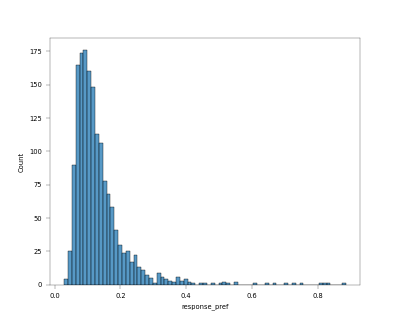

<AxesSubplot:xlabel='response_pref', ylabel='Count'>

In [22]:
fig, ax = pl.subplots()
sns.histplot(bestg['response_pref'])

### Fits for current FOV

In [23]:
gof_thr=0.5#-10000
passg = bestg[(bestg['gof']>gof_thr)].copy()
# passg=bestg.copy()

In [24]:
currg = passg[(passg.visual_area==va) & (passg.datakey==dk)].copy()
rois_ = sorted(currg['cell'].unique())
print("%i cells pass (gof=%.2f)" % (len(rois_), gof_thr))
currg.index=rois_
#df_ = pd.concat([centroids.loc[rois_], currg], axis=1)
fits = passg[(passg.visual_area==va) & (passg.datakey==dk)
           & (passg.response_pref>=-1)].copy()
rfs = rfdf[(rfdf.visual_area==va) & (rfdf.datakey==dk)].copy()
rfs.index = rfs['cell'].values
# --------------------
# combine
has_rfs = cr.get_roi_pos_and_rfs(fits, curr_rfs=rfs, rfs_only=False,
                                 position_only=False,
                                 merge_cols=['visual_area', 'datakey', 'cell'])

fits_rfs = pd.merge(fits, has_rfs, on=['visual_area', 'datakey', 'cell'], 
                        how='outer')

fits_rfs.index = fits_rfs['cell'].values
fits.index = fits['cell'].values
print(fits.shape)

78 cells pass (gof=0.50)
(78, 24)


In [32]:
curr_cells = fits[['visual_area', 'datakey', 'experiment', 'cell']].drop_duplicates().copy()
# curr_rfs = rfdf[(rfdf.visual_area==va) & (rfdf.datakey==dk)].copy()
posdf_ = cr.get_roi_pos_and_rfs(curr_cells, has_rfs, rfs_only=False, #position_only=Fals
                              merge_cols=['visual_area', 'datakey', 'cell'])
posdf_.index = posdf_['cell'].values

In [39]:
has_rfs_ = fits_rfs.dropna().copy()
top_rois_with_rfs = has_rfs_[has_rfs_.response_pref>0.1].sort_values(by=['response_pref', 'gof', 'r2comb'], \
                               ascending=False)['cell'].values
top_rois_with_rfs[0:10]

array([ 90,  91, 423, 170,  61,  31, 148, 154, 389, 135])

In [41]:
top_rois = fits[fits.response_pref>=0.1]\
                        .sort_values(by=['response_pref', 'gof', 'r2comb'], \
                               ascending=False)['cell'].values
print(len(top_rois))

plot_rois = list(top_rois_with_rfs[0:20])
print(plot_rois)

31
[90, 91, 423, 170, 61, 31, 148, 154, 389, 135, 139, 194, 202]


In [42]:
#curr_list = [90, 154, 176, 187, 256]#[123, 154, 90, 171]
# curr_list = [280, 281, 155, 123, 22, 203, 399, 262, 111]#[123, 154, 90, 171]
fits_rfs.loc[plot_rois]\
    [['cell', 'theta_pref', 'response_pref', 'x0', 'y0', 'gof']].dropna()

cell  theta_pref  response_pref         x0         y0       gof
90     90    0.000000       0.227538  24.464291  -2.506219  0.924644
91     91  264.489796       0.178409  39.571651  -7.888250  0.874693
423   423  264.489796       0.148274  26.831466  -4.283463  0.505336
170   170  242.448980       0.148154  29.924232  -5.461594  0.799958
61     61  264.489796       0.145170  30.761110  -6.132798  0.642131
31     31  235.102041       0.142748  35.673786  -4.608317  0.682797
148   148  264.489796       0.130773  32.595337  -6.772839  0.833724
154   154  264.489796       0.129924  35.969338  -8.667571  0.745872
389   389  264.489796       0.123774  31.116124  -7.689486  0.875485
135   135  124.897959       0.111978  34.964394  -7.200238  0.736317
139   139  257.142857       0.108301  32.277818  -4.025710  0.551322
194   194  315.918367       0.107350  31.657615 -10.543448  0.620320
202   202  286.530612       0.105446  28.916399  -6.982165  0.507100

# Overlay on FOV

In [51]:
plot_rois = [90, 91, 154] #, 176] # 20190616_JC097_fov1
#plot_rois = [61, 90, 91] # dk=20190616_JC097_fov1
# plot_rois = [26, 32, 107] #dk=20190511_JC083_fov1


In [52]:
session, animalid, fovnum = hutils.split_datakey_str(dk)
tfs = glob.glob(os.path.join(rootdir, animalid, session, 'FOV%i_*' % fovnum,
                      'gratings_run1', 'processed/processed*', 
                    'mcorrected*_deinterleaved', 'Channel01', 'File*', '*.tif'))
i_=[]
for t in tfs:
    im = tf.imread(t)
    i_.append(im)
imstack = np.dstack(i_)

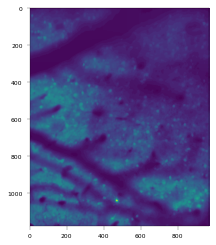

In [53]:
meanr = imstack.mean(axis=-1)
pixel_size = hutils.get_pixel_size()  
fov_transformed = retutils.transform_2p_fov(meanr, pixel_size, normalize=True)

zimg_r = pplot.adjust_image_contrast(fov_transformed, clip_limit=5.0, tile_size=5)
pl.figure()
pl.imshow(zimg_r)

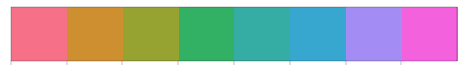

In [54]:
# colormap='cubehelix'
# cmap = mpl.cm.get_cmap(colormap, len(col_values)) # set how many colors you want in color map
# colormap = 'batlow' #'nic_Edge'
# cmapdir = '/n/coxfs01/julianarhee/colormaps' #os.path.join(aggr_dir, 'colormaps')
# cdata = np.loadtxt(os.path.join(cmapdir, colormap) + ".txt")
# cmap = mpl.colors.LinearSegmentedColormap.from_list(colormap, cdata[::-1])
# # modify colormap
# alpha = .9
# colors = []
# for ind in range(cmap.N):
#     c = []
#     for x in cmap(ind)[:3]: c.append(x*alpha)
#     colors.append(tuple(c))
# dark_cmap = mpl.colors.ListedColormap(colors, name='dark_%s' % colormap)
# mpl.cm.register_cmap("dark_%s" % colormap, dark_cmap)
# # Set colors
# ori_colors = sns.color_palette('dark_%s' % colormap, n_colors=len(tested_thetas))
# sns.palplot(sns.color_palette('dark_%s' % colormap, n_colors=len(tested_thetas)))

#sns.color_palette("husl", 8)curr_dst_dir

ori_colormap='husl'
ori_colors = sns.color_palette(ori_colormap, n_colors=len(tested_thetas))
sns.palplot(sns.color_palette(ori_colormap, n_colors=len(tested_thetas)))


In [70]:
ori_cdict = dict((k, v) for k, v in zip(tested_thetas, ori_colors))

/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/gratings_dff_ROC/pref_theta/examples saltpepper_V1_20190616_JC097_fov1__nobg_labeled
/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/gratings_dff_ROC/pref_theta/examples saltpepper_V1_20190616_JC097_fov1__nobg


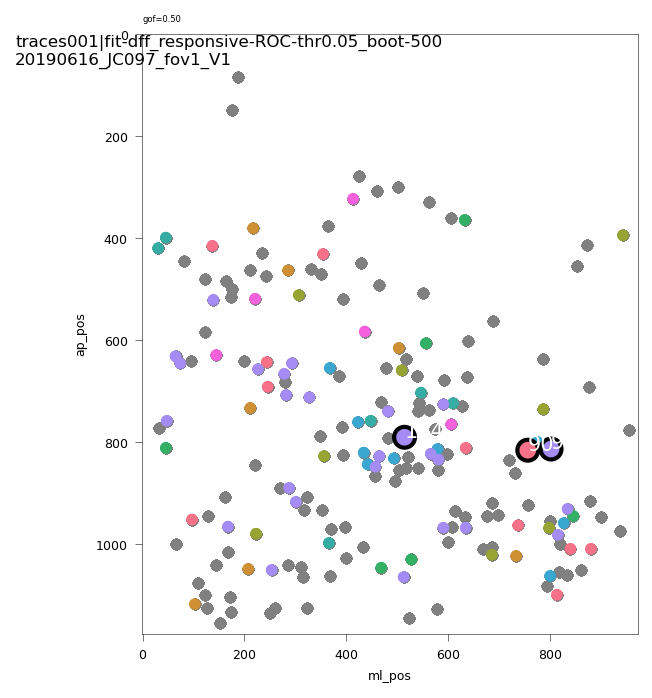

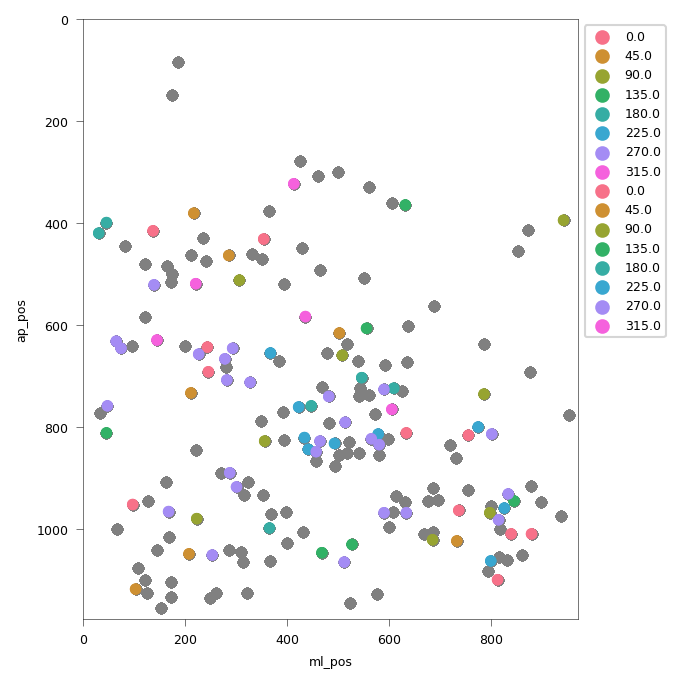

In [98]:
#highlight_rois = [27, 119, 153]
#plot_rois.extend(highlight_rois)
#plot_rois = [16, 17, 66, 91, 116, 165, 204, 215]
#plot_rois = [30, 67, 91, 163, 135, 147,215] # JC084
#plot_rois = [90, 91, 123, 142, 147, 187, 388] # JC097, 20190616
%matplotlib inline
# plot_rois=[90, 154, 171]
markersize=30

n_actual=len(fits['tested_theta'].unique())
for label_rois in [True, False]:
    #if label_rois is False:
    fig = pl.figure(figsize=(5,4), dpi=150, frameon=False)
    ax = pl.Axes(fig, [0., 0., 1., 1.])
    #ax.set_axis_off()
    fig.add_axes(ax)
    ax.imshow(zimg_r, cmap='gray', alpha=0) # if label_rois else 0)
    sns.scatterplot(x='ml_pos', y='ap_pos', data=all_cell_pos, ax=ax,
                    color=[0.5]*3, s=markersize,linewidth=0.)
    sns.scatterplot(x='ml_pos', y='ap_pos', data=fits_rfs, ax=ax,
                    hue='tested_theta', palette=ori_cdict,
                    s=markersize,linewidth=0.)
    sns.scatterplot(x='ml_pos', y='ap_pos', data=fits_rfs, ax=ax,
                    hue='tested_theta', palette=ori_cdict,
                    s=markersize,linewidth=0.)
    ax.legend(bbox_to_anchor=(1,1), loc='upper left')
    # ax.axis('off')
    if label_rois is True:
        for rid in plot_rois:
            ax.text(fits_rfs.loc[rid]['ml_pos'], fits_rfs.loc[rid]['ap_pos'], int(rid), 
                    fontsize=10, color='w')
        sns.scatterplot(x='ml_pos', y='ap_pos', 
                        data=fits_rfs[fits_rfs['cell'].isin(plot_rois)], ax=ax,
                        hue='tested_theta', palette=ori_cdict,
                        s=100,linewidth=2, edgecolor='k')
        ax.legend_.remove()
    if label_rois:
        ax.set_title('gof=%.2f' % gof_thr, fontsize=4, loc='left')
        pplot.label_figure(fig, curr_data_id)
    figname='saltpepper_%s_%s__nobg' % (va, dk) 
    if label_rois:
        figname='%s_labeled' % figname
    pl.savefig(os.path.join(examples_dir, '%s.svg' % figname))
    print(examples_dir, figname)

In [76]:
fits.loc[plot_rois][['cell', 'theta_pref',  'sf', 'size', 'speed']]

cell  theta_pref   sf   size  speed
90     90    0.000000  0.1   20.0   20.0
91     91  264.489796  0.1  200.0   10.0
154   154  264.489796  0.1  200.0   10.0

/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/gratings_dff_ROC/pref_theta/examples preftheta_histbar_V1_20190616_JC097_fov1


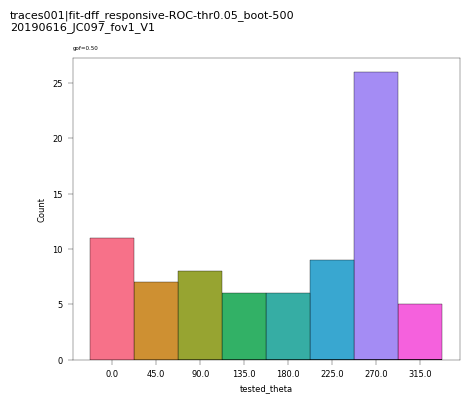

In [79]:
fig, ax = pl.subplots(figsize=(5,4), dpi=100)
sns.histplot(x='tested_theta', palette=ori_colors, alpha=1, lw=0.25,
             hue='tested_theta', data=fits, ax=ax, bins=np.arange(0, 360+45, 45))
fig.patch.set_alpha(1)
ax.set_xticks([i+(45/2.) for i in tested_thetas]) #np.arange(0, len(tested_thetas)))
ax.set_xticklabels(tested_thetas)
ax.set_title('gof=%.2f' % gof_thr, fontsize=4, loc='left')
ax.legend_.remove()

pplot.label_figure(fig, curr_data_id)
figname='preftheta_histbar_%s_%s' % (va, dk) 
pl.savefig(os.path.join(examples_dir, '%s.svg' % figname))
print(examples_dir, figname)

In [80]:
sdf_rf = aggr.get_stimuli(dk, experiment='rfs')
fit_roi_list= rfs['cell'].unique()
rfs = rfs.rename(columns={'std_x': 'sigma_x', 'std_y':'sigma_y'})
fits_rfs = fits_rfs.rename(columns={'std_x': 'sigma_x', 'std_y':'sigma_y'})
screen = hutils.get_screen_dims()

In [81]:
# ori_colordict = dict((k, v) for k, v in zip(tested_thetas, ori_colors))
# ori_colors

In [82]:
rois_ = rfs['cell'].unique()

w_ori = fits_rfs.dropna()['cell'].unique()
wout_ori = [r for r in rois_ if r not in w_ori]
ori_hues = [ori_cdict[float(fits.loc[rid]['tested_theta'])] for rid in w_ori]
len(ori_hues)

31

In [83]:
#plot_rois = [61, 90, 91, 170] #, 423] #154] #, 91] #, 154]

#plot_rois = [90, 91, 154, 176]
#plot_rois = [61, 90, 91] # dk=20190616_JC097_fov1
#plot_rois = [26, 32, 107] #dk=20190511_JC083_fov1
plot_ori_hues = [ori_cdict[float(fits.loc[rid]['tested_theta'])] \
                 for rid in plot_rois]
plot_ori_hues

[(0.9677975592919913, 0.44127456009157356, 0.5358103155058701),
 (0.6423044349219739, 0.5497680051256467, 0.9582651433656727),
 (0.6423044349219739, 0.5497680051256467, 0.9582651433656727)]

In [84]:
fits_rfs.loc[plot_rois][['response_pref','theta_pref', 'tested_theta']]

response_pref  theta_pref  tested_theta
90        0.227538    0.000000           0.0
91        0.178409  264.489796         270.0
154       0.129924  264.489796         270.0

In [85]:
# for rid in plot_rois:
#     print(fits_rfs.loc[rid]['tested_theta'])
#     print((fitdf['x0'][rid], fitdf['y0'][rid]),\
# abs(fitdf['sigma_x'][rid])*2.35, abs(fitdf['sigma_y'][rid])*2.35)


/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/gratings_dff_ROC/pref_theta/examples overlay_with_ori_V1_20190616_JC097_fov1


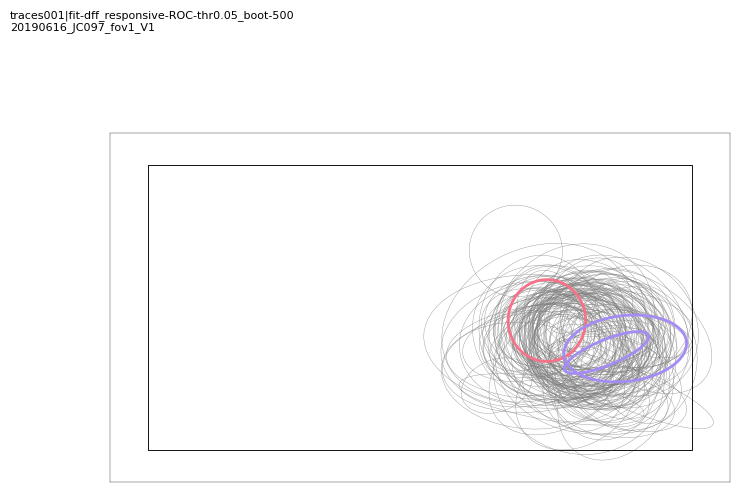

In [96]:
col = 0.5

fig, ax = pl.subplots(figsize=(8, 6), dpi=100)
#fig.patch.set_visible(False) #(False) #('off')

other_rois = [r for r in fit_roi_list if r not in plot_rois]
ax = rfutils.plot_rfs_to_screen_pretty(rfs, sdf_rf, screen, 
                               fit_roi_list=other_rois, ax=ax, 
                               roi_colors=[(col, col, col)]*len(other_rois), 
                               ellipse_lw=0.25)
# ax = rfutils.plot_rfs_to_screen_pretty(fits_rfs, sdf_rf, screen, 
#                                fit_roi_list=w_ori, ax=ax, 
#                                roi_colors=ori_hues, ellipse_lw=1)

ax = rfutils.plot_rfs_to_screen_pretty(fits_rfs, sdf_rf, screen, 
                               fit_roi_list=plot_rois, ax=ax, 
                               roi_colors=plot_ori_hues, ellipse_lw=2)
# ax.patch.set_color([0.6]*3)
# ax.patch.set_alpha(1)

pplot.label_figure(fig, curr_data_id)
figname='overlay_with_ori_%s_%s' % (va, dk) 
pl.savefig(os.path.join(examples_dir, '%s.svg' % figname))
print(examples_dir, figname)

/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/gratings_dff_ROC/pref_theta/examples/test_corr_and_distance ori_legend


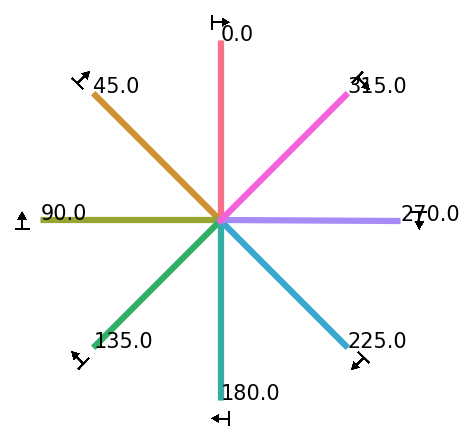

In [142]:
fig = pl.figure(figsize=(4,4), dpi=150)
fig.patch.set_alpha(1)
ax = fig.add_axes([0.1, 0.1, 0.6, 0.6], polar=True)
pplot.polar_theta_legend(ax, ori_colors)

#pplot.label_figure(fig, curr_data_id)
figname='ori_legend'
pl.savefig(os.path.join(test_dir, '%s.svg' % figname))
print(test_dir, figname)

In [44]:
# rid = 217
t_list=[]
for rid in top_rois_with_rfs[0:20]:
    ckey = tuple(fits.loc[rid][['sf', 'size', 'speed']].values)
    cfgs_ = sorted([g for g, (sf, sz, sp) in \
                    sdf[['sf', 'size', 'speed']].iterrows() \
                    if tuple([sf, sz, sp])==ckey])
    tdf = traceutils.get_mean_and_std_traces(rid, processed, labels, 
                    cfgs_, sdf, param='ori', 
                    return_stacked=True, smooth=True, win_size=9)
    tdf['has_rfs'] = ~np.isnan(posdf_.loc[rid]['x0'])
    tdf['cell']=rid
    t_list.append(tdf)
trace_ex = pd.concat(t_list, axis=0)
trace_ex = trace_ex.reset_index(drop=True)
trace_ex['sem_lo'] = trace_ex['mean'].values - trace_ex['sem'].values
trace_ex['sem_hi'] = trace_ex['mean'].values + trace_ex['sem'].values
trace_ex.head()

time ori      mean       sem  has_rfs  cell    sem_lo    sem_hi
0 -1.007768   0 -0.020398  0.037532     True    90 -0.057930  0.017134
1 -0.985373   0 -0.016304  0.037784     True    90 -0.054088  0.021481
2 -0.962978   0 -0.014435  0.037904     True    90 -0.052339  0.023469
3 -0.940583   0 -0.009662  0.037424     True    90 -0.047086  0.027762
4 -0.918189   0 -0.004397  0.038040     True    90 -0.042438  0.033643

/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/gratings_dff_ROC/pref_theta/examples top_traces_has_rfs_V1_20190616_JC097_fov1


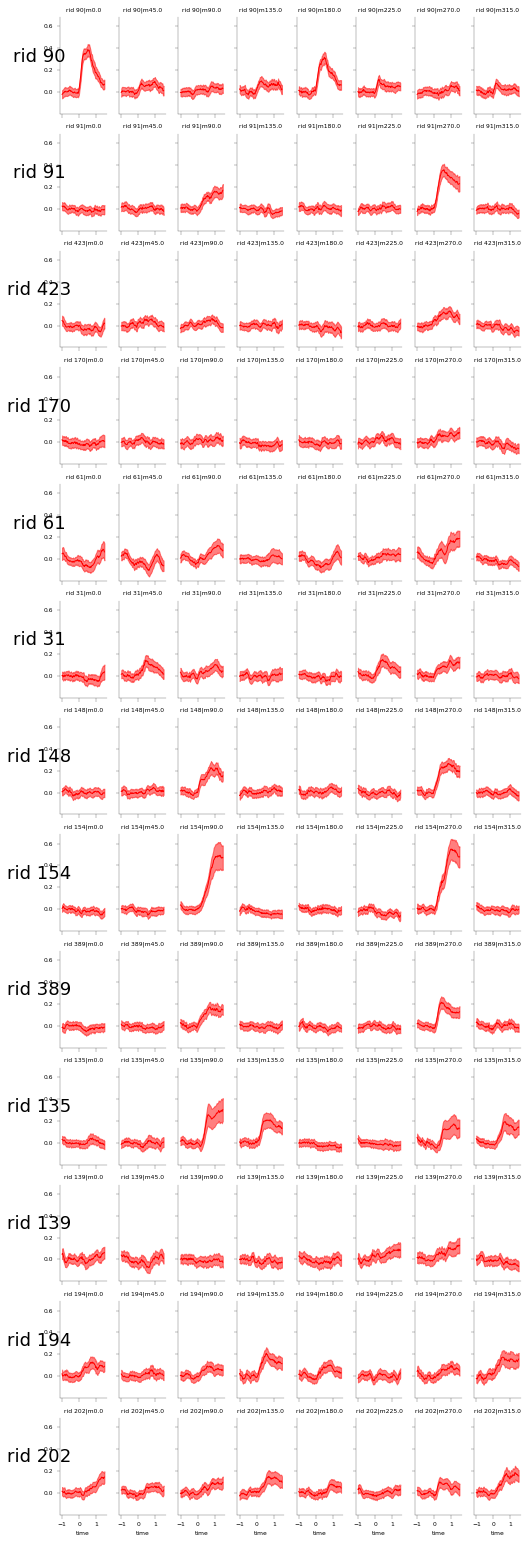

In [49]:
%matplotlib inline
fg = sns.FacetGrid(data=trace_ex, col='ori', col_order=tested_thetas, 
               row='cell', row_order=top_rois_with_rfs, 
               hue='has_rfs', palette={True: 'r', False:'b'}, height=2, aspect=0.5)
fg.map(pl.plot, 'time', 'mean', lw=1)
fg.map(pl.fill_between, 'time', 'sem_lo', 'sem_hi', alpha=0.5)
fg.fig.patch.set_alpha(1)
fg.set_titles('rid {row_name}|m{col_name}', fontsize=18)
pl.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9)
for ax in fg.fig.axes:
    rname, mlevel = ax.get_title().split('|m')
    if float(mlevel)==0:
        ax.set_ylabel(rname,rotation=0, fontsize=18)

figname = 'top_traces_has_rfs_%s_%s' % (va, dk)
pl.savefig(os.path.join(examples_dir, '%s.svg' % figname))
print(examples_dir, figname)

In [89]:
plot_rois = [90, 91, 154]

In [91]:
fits.loc[rid]

response_pref                 0.227538
response_null                 0.183103
theta_pref                         0.0
sigma                        24.509841
response_offset               0.036746
asi                           0.734956
dsi                           0.204241
circvar_asi                   0.849286
circvar_dsi                   0.492656
r2                            0.959852
cell                                90
r2comb                        0.966199
gof                           0.924644
sf                                 0.1
size                              20.0
speed                             20.0
visual_area                         V1
datakey            20190616_JC097_fov1
animalid                         JC097
fov                      FOV1_zoom2p0x
session                       20190616
tf                                 2.0
tested_theta                       0.0
experiment                    gratings
Name: 90, dtype: object

90 0.0
91 270.0
154 270.0


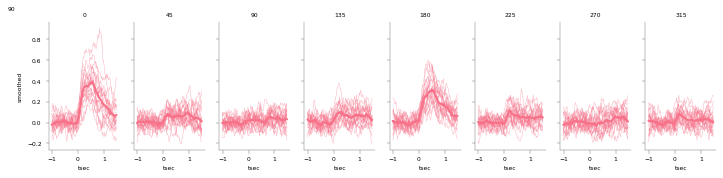

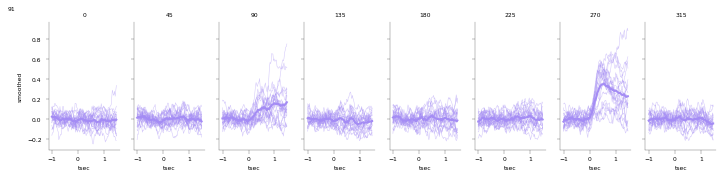

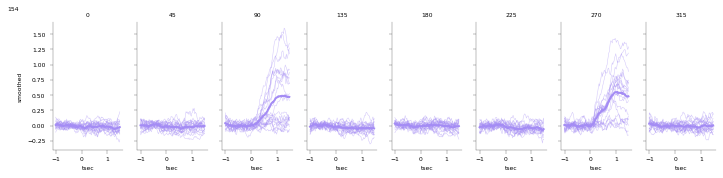

In [95]:
# r1, r2 = cpair
# cc, dist = pw_df[pw_df['neuron_pair']=='%s_%i' % (r1, r2)]\
#             [['pearsons_morph', 'cortical_distance']].values[0]
tdf = trace_ex[trace_ex['cell'].isin(plot_rois)].copy()
rid_colors={}
#tdf.head()
for rid, td in tdf.groupby('cell'):
#     best_m = float(best_ixs.loc[rid]['best_morphlevel'])
#     best_s = float(best_ixs.loc[rid]['best_size'])
#     tdf.loc[td.index, 'best_morphlevel'] = best_m
#     tdf.loc[td.index, 'best_size'] = best_s
    ptheta = float(fits.loc[rid]['tested_theta'])
    ckey = tuple(fits.loc[rid][['sf', 'size', 'speed']].values)
    cfgs_ = sorted([g for g, (sf, sz, sp) in \
                    sdf[['sf', 'size', 'speed']].iterrows() \
                    if tuple([sf, sz, sp])==ckey])
    print(rid, ptheta)
    rid_colors.update({rid: ori_cdict[ptheta]})
    roidf = traceutils.roi_traces_df(rid, processed, labels, sdf, params=['ori'], 
                         cfgs_=cfgs_, smooth_win_size=9)
    fig = traceutils.plot_raw_traces_tuning_curve(roidf, response_var='smoothed', 
                                    param='ori', color=rid_colors[rid],
                                    lw=2, trial_lw=0.5, trial_alpha=0.5)
    fig.text(0.0, 0.95, rid, fontsize=6)
    figname = 'rawtrace_rid%i_%s_%s' % (rid, va, dk)
    pl.savefig(os.path.join(examples_dir, '%s.svg' % figname))

In [ ]:
mlevel

## PW distances

In [93]:
# r1=123
# p = df_[df_.cell==r1][['ml_pos', 'ap_pos']].values
# r2 = 154
# q = df_[df_.cell==r2][['ml_pos', 'ap_pos']].values
# np.linalg.norm(p-q)

# Get PW differences (tuning)
tuning_dists = cr.correlate_pw_tuning_in_fov(fits,
                                      n_intervals=3, stimulus='gratings') 

In [94]:
# Cortical and RF position distances
dists = cr.get_pw_distance(tuning_dists, posdf_, xcoord='x0', ycoord='y0', 
                         label='rf_distance', add_eccentricity=True)

In [95]:
dists0=dists.copy()
rois_ = fits['cell'].unique()
curr_polys = rfpolys[(rfpolys.datakey==dk) & (rfpolys['cell'].isin(rois_))] 

rf_diffs = cr.rf_diffs_and_dists_in_fov(dists0, posdf_, curr_polys=curr_polys)
pw_df= pd.merge(dists, rf_diffs, on=['neuron_pair', 'cell_1', 'cell_2'], 
                how='outer')

In [97]:
pw_df.shape, pw_df.dropna().shape, dk

((2145, 23), (253, 23), '20190511_JC083_fov1')

In [98]:
#plot_rois = [61, 90, 91] # dk=20190616_JC097_fov1
# plot_rois = [26, 32, 107] #dk=20190511_JC083_fov1

plot_pairs = list(itertools.combinations(plot_rois, 2))

plot_pair_labels = ['%i_%i' % (r1, r2) for (r1, r2) in plot_pairs]
plot_pair_labels

['26_32', '26_107', '32_107']

In [99]:
ctx_maxdist = 1000
ctx_step = 50
ctx_bins = np.arange(0, ctx_maxdist+ctx_step, ctx_step)

plotd = pw_df[pw_df.cortical_distance<=ctx_maxdist].copy().dropna()
plotd = cr.cut_bins(plotd, ctx_bins, 'cortical_distance')

perc_max=1
perc_step=0.05
perc_bins = np.arange(0, perc_max+perc_step, perc_step)
plotd = cr.cut_bins(plotd, perc_bins, 'area_overlap')

rf_maxdist = 60
rf_step = 2
rf_bins = np.arange(0, rf_maxdist+rf_step, rf_step)
plotd = cr.cut_bins(plotd, rf_bins, 'rf_distance')

In [100]:
grouped_hue_min = plotd.groupby([x_var_name, y_var_name])[hue_var].mean().min()
grouped_hue_max = plotd.groupby([x_var_name, y_var_name])[hue_var].mean().max()
print(grouped_hue_min, grouped_hue_max)

-0.9368160341728494 0.9657818595609289


-0.9368160341728494 0.9657818595609289


<IPython.core.display.Javascript object>


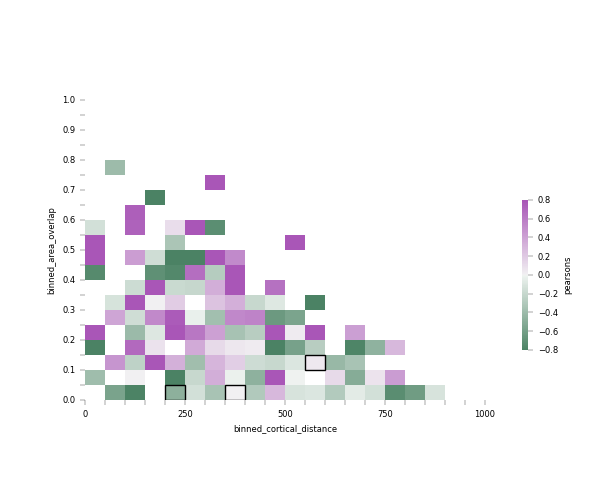

In [101]:
%matplotlib notebook
x_var = 'cortical_distance'
y_var = 'area_overlap'
hue_var = 'pearsons'
hue_min, hue_max = (-.8, 0.8)
cmap=sns.diverging_palette(145, 300, s=60, as_cmap=True)
#'coolwarm'

# x_var_name = 'binned_%s' % x_var
# y_var_name = 'binned_%s' % y_var
x_var_name = '%s_label' % x_var
y_var_name = '%s_label' % y_var
x_vals = [k for k, v in plotd.groupby(x_var_name)]
y_vals = [k for k, v in plotd.groupby(y_var_name)]
plotd['%s_index' % x_var_name] = [x_vals.index(i) for i \
                                    in plotd[x_var_name]]
plotd['%s_index' % y_var_name] = [y_vals.index(i) for i \
                                    in plotd[y_var_name]]

grouped_hue_min = plotd.groupby([x_var_name, y_var_name])[hue_var].mean().min()
grouped_hue_max = plotd.groupby([x_var_name, y_var_name])[hue_var].mean().max()
print(grouped_hue_min, grouped_hue_max)
x_bins = ctx_bins.copy()
y_bins = perc_bins.copy()
#
fig, ax = pl.subplots(figsize=(6, 5), dpi=150)
fig.patch.set_alpha(1)
cbar_ax = fig.add_axes([0.87, 0.3, 0.01, 0.3])
means_ = plotd.groupby(['binned_%s' % y_var, 'binned_%s' % x_var])\
           .mean().reset_index()
hmat = means_.pivot('binned_%s' % y_var, 'binned_%s' % x_var, hue_var)
sns.heatmap(hmat, cmap=cmap, ax=ax, vmin=hue_min, vmax=hue_max,
            cbar=1, cbar_ax=cbar_ax, cbar_kws={'label': hue_var}) 
ax.set_box_aspect(0.75)
#, center=0)
ax.set_box_aspect(0.75)
ax.set_yticks(np.arange(0, len(y_bins)))
ax.set_yticklabels([round(i, 2) if i in y_bins[0::2] else '' for i in y_bins])
ax.set_xticks(np.arange(0, len(x_bins)))
ax.set_xticklabels([int(i) if i in x_bins[0::5] else '' for i in x_bins])
ax.invert_yaxis()
# 
for currpair in plot_pair_labels:
    row_v = float(plotd[plotd.neuron_pair==currpair][y_var_name])
    col_v =  float(plotd[plotd.neuron_pair==currpair][x_var_name])
    xv_, yv_, = x_vals.index(col_v), y_vals.index(row_v)
    hv_ = float(plotd[plotd.neuron_pair==currpair][y_var])
    ax.add_patch(mpl.patches.Rectangle((xv_, yv_), 1, 1, 
                                       fill=False, edgecolor='k', lw=1))
    
pl.subplots_adjust(left=0.1, right=0.85, bottom=0.2, top=0.8, wspace=0.5)


<IPython.core.display.Javascript object>


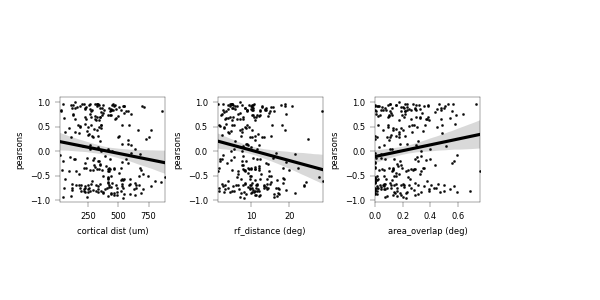

No handles with labels found to put in legend.
No handles with labels found to put in legend.


    val out of bounds
BINNED, no fit: V1
    val out of bounds
BINNED, no fit: V1


No handles with labels found to put in legend.


    val out of bounds
BINNED, no fit: V1


In [102]:
%matplotlib notebook
metric='pearsons'
params = ['cortical_distance', 'rf_distance', 'area_overlap']
fit_sites = False
use_binned=True
min_npairs = 3
n_iter=int(np.random.rand(1)[0]*500)


fig, axn = pl.subplots(1, len(params), figsize=(6,3), dpi=150)
fig.patch.set_alpha(1)

for ax, to_quartile in zip(axn.flat, params):
    xlabel='cortical dist (um)' if to_quartile=='cortical_distance' else '%s (deg)' % to_quartile
    if fit_sites:
        cnt_grouper.append('datakey')
    x_var = '%s_label' % to_quartile
    cnt_grouper = [x_var] 
    
    cnts = plotd.groupby(cnt_grouper)['neuron_pair'].count()  
    # How many resample per group
    nsamples_per = dict((k, v) for k, v \
                        in zip(cnts[cnts>min_npairs].index.tolist(),
                               cnts[cnts>min_npairs].values))
    # Sample
    cc_ = pd.concat([cg.sample(nsamples_per[c], random_state=n_iter, replace=True) \
                         for c, cg in plotd.groupby(cnt_grouper) \
                         if c in nsamples_per.keys()])
    # fov mean for visualizing
    if fit_sites:
        fit_cc = cc_.groupby(cnt_grouper).median().reset_index().dropna()
    else:
        fit_cc = cc_.copy()

    # plot
    meas_cc = plotd.groupby(cnt_grouper).median().reset_index().dropna()
    #ax.scatter(x=to_quartile, y=metric, data=plotd, s=2, color='k')
    sns.regplot(x=to_quartile, y=metric, data=plotd, color='k',
               scatter_kws={'s':1}, ax=ax)
    res_, xvals, yvals = cr.fit_decay_on_binned(fit_cc, use_binned=use_binned,
                                            normalize_x=True, func='halflife',
                                            estimator='median',
                                            metric=metric,
                                            to_quartile=to_quartile,
                                            return_inputs=True)
    if all(res_.isnull()):
        print("BINNED, no fit: %s" % va)
        label='no fit'
    else:
        fit_y = cr.func_halflife(xvals, res_.init, res_.tau, res_.constant)
        label = '%s (T=%.2f)\ninit: %.1f, c=%.2f\nR2=%.2f' \
                        % (va, res_.tau, res_.init, res_.constant, res_.R2)
        ax.plot(xvals, fit_y, color='r', label=label)
    ax.set_ylabel(metric)
    ax.set_xlabel(xlabel)
    ax.legend(bbox_to_anchor=(1,1), loc='lower right', frameon=False, ncol=1)
    ax.set_box_aspect(1)
    #ax.set_xlim([0, 250])
#ax.set_ylim([0, 0.7])
pl.subplots_adjust(bottom=0.3, left=0.1, right=0.8, top=0.7, wspace=0.5)

In [1333]:
dists.columns

Index(['xcorr', 'pearsons', 'cosim', 'cell_1', 'cell_2', 'neuron_pair',
       'rf_distance', 'max_ecc', 'min_ecc', 'cortical_distance',
       'pref_dir_diff', 'pref_dir_diff_abs', 'pref_ori_diff',
       'pref_ori_diff_abs', 'response_pref', 'sigma'],
      dtype='object')

In [877]:
dists['pref_ori_diff_abs'] = dists['pref_ori_diff'].abs()
dists['pref_dir_diff_abs'] = dists['pref_dir_diff'].abs()
dists['pearsons_abs'] = dists['pearsons'].abs()

<IPython.core.display.Javascript object>


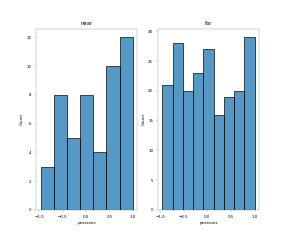

Text(0.5, 1.0, 'far')

In [878]:
%matplotlib notebook
plotd = dists[dists.cortical_distance<=500].copy()

fig, axn = pl.subplots(1, 2, figsize=(6,5))
ax=axn[0]
sns.histplot(x='pearsons', data=plotd[plotd.cortical_distance<=50], ax=ax)
ax.set_title('near')

ax=axn[1]
sns.histplot(x='pearsons', data=plotd[plotd.cortical_distance>450], ax=ax)
ax.set_title('far')

In [879]:
# Split distances into X um bins
ctx_step=10
ctx_maxdist=250
ctx_bins = np.arange(0, ctx_maxdist+ctx_step, ctx_step)
ctx_bins = [int(i) for i in ctx_bins]

df=dists.copy()
df = cr.cut_bins(df, ctx_bins, 'cortical_distance')

In [880]:
plotd = df[df.cortical_distance<=ctx_maxdist].copy()

<IPython.core.display.Javascript object>


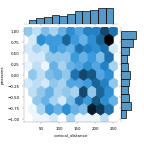

In [881]:
%matplotlib notebook
fg= sns.jointplot(x='cortical_distance', y='pearsons', data=plotd,
             kind='hex', height=3, ) #, joint_kws={'bins': ctx_bins})


In [882]:
dk

'20190616_JC097_fov1'

<IPython.core.display.Javascript object>


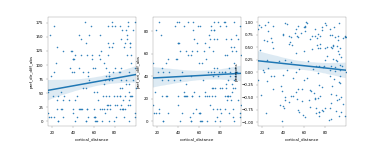

pref_dir_diff_abs: R=0.15, p=0.05
pref_ori_diff_abs: R=0.04, p=0.58
pearsons: R=-0.09, p=0.24


In [1025]:
metrics = ['pref_dir_diff_abs', 'pref_ori_diff_abs', 'pearsons']
plotd = dists[dists.cortical_distance<=100].copy()
fig, axn = pl.subplots(1,len(metrics), figsize=(8,3))

for ax, metric in zip(axn.flat, metrics):
    r, p = spstats.pearsonr(plotd['cortical_distance'], plotd[metric])
    print('%s: R=%.2f, p=%.2f' % (metric, r, p))
    sns.regplot(x='cortical_distance', y=metric, data=plotd, ax=ax,
                   scatter_kws={'s': 2})
    

In [1026]:
neg_corr_cells = dists[(dists.pearsons<0) & (dists.cortical_distance<50)]
neg_corr_cells.shape

(20, 17)

In [1029]:
check_cells = np.union1d(neg_corr_cells['cell_1'].unique(), neg_corr_cells['cell_2'].unique())

check_pairs = [(int(v.split('_')[0]), int(v.split('_')[1])) \
               for v in neg_corr_cells['neuron_pair'].values]
check_pairs

[(18, 35),
 (26, 31),
 (32, 34),
 (33, 34),
 (34, 42),
 (90, 91),
 (90, 92),
 (123, 139),
 (123, 147),
 (139, 142),
 (145, 149),
 (161, 176),
 (168, 169),
 (205, 212),
 (206, 212),
 (206, 214),
 (208, 214),
 (212, 353),
 (403, 412),
 (411, 412)]

In [157]:
fit_params=['response_pref', 'response_null', 'theta_pref', 'sigma', 'response_offset']     
thetas = osi.interp_values(tested_thetas, n_intervals=3, wrap_value=360)
# cpopt = tuple(df.loc[rid][fit_params].values)       
# fitv = osi.double_gaussian( thetas, *cpopt)  

In [158]:
trialmetrics[trialmetrics.config.isin(cfgs_)][[rid, 'config']]\
    .groupby('config').mean().reset_index()

config        26
0  config004  0.012003
1  config009  0.039424
2  config014  0.200049
3  config019  0.146236
4  config024  0.078411
5  config029  0.004825
6  config034  0.406615
7  config039  0.094583

In [159]:
%matplotlib notebook
for cpair in check_pairs:
    r1, r2 = cpair
    rid_colors={r1: 'r', r2: 'b'}
    cc, dist = neg_corr_cells[neg_corr_cells['neuron_pair']=='%s_%i' % (r1, r2)]\
                [['pearsons', 'cortical_distance']].values[0]

    t_=[]
    means_={}
    for rid in cpair:
        ckey = tuple(fits.loc[rid][['sf', 'size', 'speed']].values)
        cfgs_ = sorted([g for g, (sf, sz, sp) in \
                        sdf[['sf', 'size', 'speed']].iterrows() \
                        if tuple([sf, sz, sp])==ckey])
        tdf = traceutils.get_mean_and_std_traces(rid, processed, labels, 
                        cfgs_, sdf, return_stacked=True, smooth=True, win_size=5)
        tdf['cell'] = rid
        t_.append(tdf)
        meanr = trialmetrics[trialmetrics.config.isin(cfgs_)][[rid, 'config']]\
                        .groupby('config').mean()
        means_[rid] = meanr
    tdf = pd.concat(t_, axis=0).reset_index(drop=True)
    fg = sns.FacetGrid(data=tdf, col='ori', col_order=tested_thetas, 
                   height=2, aspect=1, hue='cell', palette=rid_colors)
    fg.map(pl.plot, 'time', 'mean', lw=1)
    pl.subplots_adjust(left=0.1, right=0.7, bottom=0.3, top=0.8)
    # Add fit
    ax = fg.fig.add_axes([0.7, 0.5, 0.25, 0.25], polar=True) #1, 9, 9, polar=True)
    for rid in cpair:
        thetas = osi.interp_values(tested_thetas, n_intervals=3, wrap_value=360)
        cpopt = tuple(fits.loc[rid][fit_params].values)       
        fitv = osi.double_gaussian( thetas, *cpopt)  
        meanr = means_[rid][rid].values
        if meanr.min()<0:
            meanr -= meanr.min()
        truv = np.array(osi.interp_values(meanr, n_intervals=3, wrap_value=meanr[-1]))
        _, ax = osi.polar_plot_roi(thetas, truv, curr_sems=None, response_type='dff', 
                                   fig=fg.fig, ax=ax, color=rid_colors[rid],
                                  linestyle=':')
        _, ax = osi.polar_plot_roi(thetas, fitv, curr_sems=None, response_type='dff', 
                                   fig=fg.fig, ax=ax, color=rid_colors[rid] )
    fg.fig.text(0.01, 0.9, 'rid %i vs %i\n(cc=%.2f, D=%.2f)' % (r1, r2, cc, dist),
               fontsize=10)
    ax=fg.fig.axes[-2]
    leg_h = pplot.custom_legend_markers(colors=[rid_colors[r] for r in [r1,r2]],
                    labels=[r1, r2])
    ax.legend(handles=leg_h, bbox_to_anchor=(1,1), frameon=False, loc='upper left')

NameError: name 'check_pairs' is not defined

In [160]:
# import sys
# # !conda install --yes --prefix {sys.prefix} skimage
# !{sys.executable} -m pip install skimage

In [143]:
import analyze2p.objects.sim_utils as su

In [144]:
rf_fit_desc = rfutils.get_fit_desc(response_type=response_type,
                                  do_spherical_correction=do_spherical_correction)

In [145]:
print(rf_fit_desc)
try:
    rfpolys, _ = su.load_rfpolys(rf_fit_desc)
except FileNotFoundError as e:
    rfpolys, check_rfs = su.update_rfpolys(rfdf, rf_fit_desc, create_new=True)

fit-2dgaus_dff-no-cutoff


In [146]:
# overlaps_=None
# if rfpolys is not None:
#     rois_ = fits_rfs['cell'].unique()
#     curr_polys = rfpolys[(rfpolys.datakey==dk) & (rfpolys['cell'].isin(rois_))]
#     overlaps_ = rfutils.get_rf_overlaps(curr_polys)
#     overlaps_ = overlaps_.rename(columns={'poly1': 'cell_1', 'poly2': 'cell_2'})
#     overlaps_['neuron_pair'] = ['%i_%i' % (c1, c2) for c1, c2 \
#                                     in overlaps_[['cell_1', 'cell_2']].values] 
rois_ = fits['cell'].unique()
curr_polys = rfpolys[(rfpolys.datakey==dk) & (rfpolys['cell'].isin(rois_))]
#print(dk, curr_polys.shape)
if len(curr_polys)<=1:
    print("    (%s NONE, skipping overlaps)" % dk) 

overlaps_ = rfutils.get_rf_overlaps(curr_polys)
overlaps_ = overlaps_.rename(columns={'poly1': 'cell_1', 'poly2': 'cell_2'})
overlaps_['neuron_pair'] = ['%i_%i' % (c1, c2) for c1, c2 \
                                in overlaps_[['cell_1', 'cell_2']].values] 
# RF angle diffs
rf_ang_ = cr.get_pw_angular_dist(posdf_, tau=180,
                          in_name='rf_theta_deg', out_name='rf_angle_diff')
rf_diffs = pd.merge(overlaps_, rf_ang_, on=['neuron_pair', 'cell_1', 'cell_2'])


In [147]:
rf_diffs

cell_1  cell_2  area_overlap  perc_overlap neuron_pair  rf_angle_diff  \
0       4.0    24.0      0.513216      0.741099        4_24     -35.949648   
1       4.0    26.0      0.070264      0.945030        4_26      57.203790   
2       4.0    31.0      0.102696      0.541499        4_31      76.377690   
3       4.0    32.0      0.123865      0.910225        4_32       0.891157   
4       4.0    33.0      0.162516      0.399926        4_33     -74.629536   
..      ...     ...           ...           ...         ...            ...   
295   143.0   154.0      0.360699      1.000000     143_154            NaN   
296   143.0   166.0      0.727177      0.996219     143_166     -16.353537   
297   151.0   154.0      0.246277      0.470573     151_154            NaN   
298   151.0   166.0      0.208167      0.655269     151_166      26.412411   
299   154.0   166.0      0.492787      1.000000     154_166            NaN   

     rf_angle_diff_abs  
0            35.949648  
1            57.203790  
2            76.377690  
3             0.891157  
4            74.629536  
..                 ...  
295                NaN  
296          16.353537  
297                NaN  
298          26.412411  
299                NaN  

[300 rows x 7 columns]

In [148]:
DISTS = pd.merge(dists, rf_diffs, on=['neuron_pair', 'cell_1', 'cell_2'],
                how='outer')

In [149]:
DISTS.shape, dists.shape

((2145, 20), (2145, 16))

In [150]:
plot_rois

[26, 32, 107]

In [151]:
plot_pairs = ['%i_%s' % (i, v) for (i, v) \
              in list(itertools.combinations(plot_rois, 2))]
plot_pairs

['26_32', '26_107', '32_107']

<IPython.core.display.Javascript object>


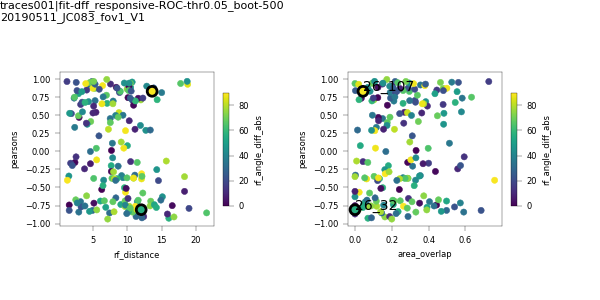

/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/gratings_dff_ROC/pref_theta/examples/test_corr_and_distance area_overlap_v_pearsons_hue-rf_angle_diff_abs_V1_20190511_JC083_fov1


In [154]:
%matplotlib notebook
markersize = 20
cmap='viridis'
plotd = DISTS[DISTS.cortical_distance<=500].copy()

x_var = 'rf_distance'
y_var = 'pearsons'
hue_var = 'rf_angle_diff_abs'
hue_min, hue_max = (0, 90)
#
fig, axn = pl.subplots(1, 2, figsize=(6,3), dpi=150)
fig.patch.set_alpha(1)

ax=axn[0]
sns.scatterplot(x=x_var, y=y_var, data=plotd, ax=ax,
                hue=hue_var, palette=cmap, edgecolor=None,
                hue_norm=(hue_min, hue_max), s=markersize)
sns.scatterplot(x=x_var, y=y_var, 
                data=plotd[plotd['neuron_pair'].isin(plot_pairs)], ax=ax,
                hue=hue_var, palette=cmap, s=50,
                edgecolor='k', linewidth=2, hue_norm=(hue_min, hue_max))
#ax.legend_.remove()
norm = pl.Normalize(hue_min, hue_max)
sm = pl.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
fig.colorbar(sm, ax=ax, orientation='vertical', shrink=0.5, label=hue_var)
ax.legend_.remove()
ax.set_box_aspect(1)

ax=axn[1]
x_var = 'area_overlap'
# hue_var = 'rf_angle_diff_abs'
# hue_min, hue_max = (0, 90)

sns.scatterplot(x=x_var, y=y_var, data=plotd, ax=ax,
                hue=hue_var, palette=cmap, edgecolor=None,
                hue_norm=(hue_min, hue_max), s=markersize)
sns.scatterplot(x=x_var, y=y_var, 
                data=plotd[plotd['neuron_pair'].isin(plot_pairs)], ax=ax,
                hue=hue_var, palette=cmap, s=50,
                edgecolor='k', linewidth=2, hue_norm=(hue_min, hue_max))
#ax.legend_.remove()
norm = pl.Normalize(hue_min, hue_max)
sm = pl.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
fig.colorbar(sm, ax=ax, orientation='vertical', shrink=0.5, label=hue_var)
ax.legend_.remove()
ax.set_box_aspect(1)
for p in plot_pairs:
    if p not in plotd.neuron_pair.values:
        continue
    x=float(plotd[(plotd.neuron_pair)==p][x_var])
    y=float(plotd[(plotd.neuron_pair)==p][y_var])
    ax.text(x, y, p)

pl.subplots_adjust(left=0.1, right=0.9, wspace=0.5)

pplot.label_figure(fig, curr_data_id)
figname='%s_v_%s_hue-%s_%s_%s' % (x_var, y_var, hue_var, va, dk) 
pl.savefig(os.path.join(test_dir, '%s.svg' % figname))
print(test_dir, figname)

In [153]:
plotd[(plotd.neuron_pair)==p][x_var]

Series([], Name: area_overlap, dtype: float64)

<IPython.core.display.Javascript object>


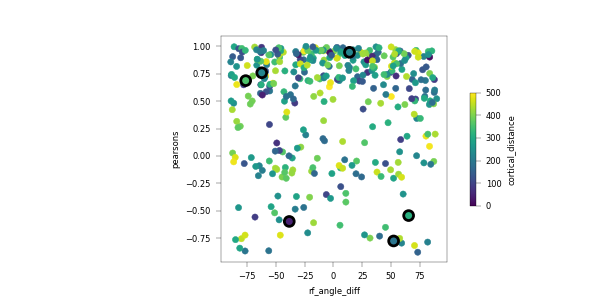

In [1396]:
%matplotlib notebook
markersize = 20
cmap='viridis'
plotd = DISTS[DISTS.cortical_distance<=500].copy()

x_var = 'rf_angle_diff'
y_var = 'pearsons'
hue_var = 'cortical_distance'
hue_min, hue_max = (0, 500)
#
fig, ax = pl.subplots(figsize=(6,3), dpi=150)
fig.patch.set_alpha(1)

sns.scatterplot(x=x_var, y=y_var, data=plotd, ax=ax,
                hue=hue_var, palette=cmap, edgecolor=None,
                hue_norm=(hue_min, hue_max), s=markersize)
sns.scatterplot(x=x_var, y=y_var, 
                data=plotd[plotd['neuron_pair'].isin(plot_pairs)], ax=ax,
                hue=hue_var, palette=cmap, s=50,
                edgecolor='k', linewidth=2, hue_norm=(hue_min, hue_max))
#ax.legend_.remove()
norm = pl.Normalize(hue_min, hue_max)
sm = pl.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
fig.colorbar(sm, ax=ax, orientation='vertical', shrink=0.5, label=hue_var)
ax.legend_.remove()
ax.set_box_aspect(1)


In [1355]:
plotd[(plotd.neuron_pair)==p][x_var]

Series([], Name: rf_angle_diff_abs, dtype: float64)

'/n/coxfs01/julianarhee/aggregate-visual-areas/gratings-tuning/traces001-fit-dff_responsive-ROC-thr0.05_boot-500'

In [155]:
plot_pairs_int = [(int(v.split('_')[0]), int(v.split('_')[1])) \
                   for v in plot_pairs]
plot_pairs_int

[(26, 32), (26, 107), (32, 107)]

<IPython.core.display.Javascript object>


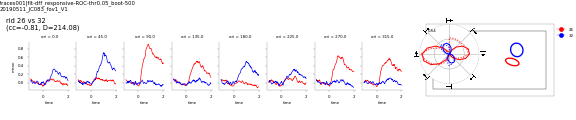

/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/gratings_dff_ROC/pref_theta/examples/test_corr_and_distance compare_tuning_rid_26_32__V1_20190511_JC083_fov1


<IPython.core.display.Javascript object>


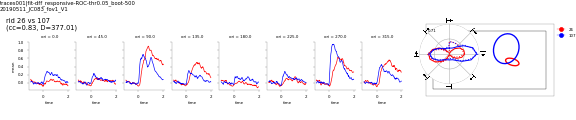

/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/gratings_dff_ROC/pref_theta/examples/test_corr_and_distance compare_tuning_rid_26_107__V1_20190511_JC083_fov1


<IPython.core.display.Javascript object>


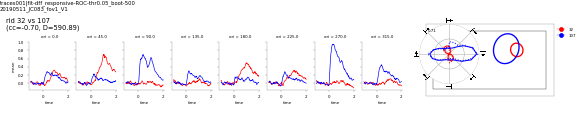

/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/gratings_dff_ROC/pref_theta/examples/test_corr_and_distance compare_tuning_rid_32_107__V1_20190511_JC083_fov1


In [161]:
%matplotlib notebook
for cpair in plot_pairs_int:
    r1, r2 = cpair
    rid_colors={r1: 'r', r2: 'b'}
    cc, dist = DISTS[DISTS['neuron_pair']=='%s_%i' % (r1, r2)]\
                [['pearsons', 'cortical_distance']].values[0]
    t_=[]
    means_={}
    for rid in cpair:
        ckey = tuple(fits.loc[rid][['sf', 'size', 'speed']].values)
        cfgs_ = sorted([g for g, (sf, sz, sp) in \
                        sdf[['sf', 'size', 'speed']].iterrows() \
                        if tuple([sf, sz, sp])==ckey])
        tdf = traceutils.get_mean_and_std_traces(rid, processed, labels, 
                        cfgs_, sdf, return_stacked=True, smooth=True, win_size=5)
        tdf['cell'] = rid
        t_.append(tdf)
        meanr = trialmetrics[trialmetrics.config.isin(cfgs_)][[rid, 'config']]\
                        .groupby('config').mean()
        means_[rid] = meanr
    tdf = pd.concat(t_, axis=0).reset_index(drop=True)
    fg = sns.FacetGrid(data=tdf, col='ori', col_order=tested_thetas, 
                   height=2.5, aspect=0.6, hue='cell', palette=rid_colors)
    fg.map(pl.plot, 'time', 'mean', lw=1)
    fg.fig.patch.set_alpha(1)
    pl.subplots_adjust(left=0.05, right=0.7, bottom=0.25, top=0.65)
    # RFs
    ax = fg.fig.add_axes([0.55, 0.2, 0.6, 0.6], polar=False)
    pair_rfs = fits_rfs[fits_rfs.cell.isin(cpair)]
    plot_ori_hues = [ori_colordict[float(fits.loc[rid]['tested_theta'])] \
                     for rid in cpair]
    ax = rfutils.plot_rfs_to_screen_pretty(pair_rfs, sdf_rf, screen, 
                                   fit_roi_list=cpair, ax=ax, 
                                   roi_colors=[rid_colors[r] for r in cpair], 
                                   ellipse_lw=2)
    #ax = fig.add_axes([0.1, 0.5, 0.4, 0.4], polar=True)
    #pplot.polar_theta_legend(ax, ori_colors)
    # Add fit
    ax = fg.fig.add_axes([0.53, 0.3, 0.5, 0.5], polar=True) #1, 9, 9, polar=True)
    for rid in cpair:
        thetas = osi.interp_values(tested_thetas, n_intervals=3, wrap_value=360)
        cpopt = tuple(fits.loc[rid][fit_params].values)       
        fitv = osi.double_gaussian( thetas, *cpopt)  
        meanr = means_[rid][rid].values
        if meanr.min()<0:
            meanr -= meanr.min()
        truv = np.array(osi.interp_values(meanr, n_intervals=3, wrap_value=meanr[-1]))
        _, ax = osi.polar_plot_roi(thetas, truv, curr_sems=None, response_type='dff', 
                                   fig=fg.fig, ax=ax, color=rid_colors[rid],
                                  linestyle=':')
        _, ax = osi.polar_plot_roi(thetas, fitv, curr_sems=None, response_type='dff', 
                                   fig=fg.fig, ax=ax, color=rid_colors[rid] )
    ylim = ax.get_ylim()[-1].round(2)
    pplot.polar_ticks_gratings(ax, ylim=ylim, ytick_lim=ylim, n_yticks=3)     
        
    fg.fig.text(0.01, 0.75, 'rid %i vs %i\n(cc=%.2f, D=%.2f)' % (r1, r2, cc, dist),
               fontsize=10)
    ax=fg.fig.axes[-2]
    leg_h = pplot.custom_legend_markers(colors=[rid_colors[r] for r in [r1,r2]],
                    labels=[r1, r2])
    ax.legend(handles=leg_h, bbox_to_anchor=(1,1), frameon=False, loc='upper left')

    pplot.label_figure(fg.fig, curr_data_id)
    figname='compare_tuning_rid_%s__%s_%s' % ('%i_%i' % (r1, r2), va, dk) 
    pl.savefig(os.path.join(test_dir, '%s.svg' % figname))
    print(test_dir, figname)


<IPython.core.display.Javascript object>


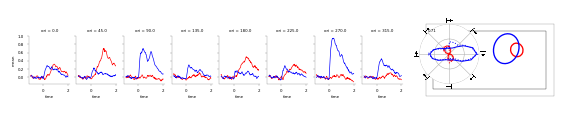

In [162]:
    r1, r2 = cpair
    rid_colors={r1: 'r', r2: 'b'}
    cc, dist = DISTS[DISTS['neuron_pair']=='%s_%i' % (r1, r2)]\
                [['pearsons', 'cortical_distance']].values[0]
    t_=[]
    means_={}
    for rid in cpair:
        ckey = tuple(fits.loc[rid][['sf', 'size', 'speed']].values)
        cfgs_ = sorted([g for g, (sf, sz, sp) in \
                        sdf[['sf', 'size', 'speed']].iterrows() \
                        if tuple([sf, sz, sp])==ckey])
        tdf = traceutils.get_mean_and_std_traces(rid, processed, labels, 
                        cfgs_, sdf, return_stacked=True, smooth=True, win_size=5)
        tdf['cell'] = rid
        t_.append(tdf)
        meanr = trialmetrics[trialmetrics.config.isin(cfgs_)][[rid, 'config']]\
                        .groupby('config').mean()
        means_[rid] = meanr
    tdf = pd.concat(t_, axis=0).reset_index(drop=True)
    fg = sns.FacetGrid(data=tdf, col='ori', col_order=tested_thetas, 
                   height=2.5, aspect=0.6, hue='cell', palette=rid_colors)
    fg.map(pl.plot, 'time', 'mean', lw=1)
    fg.fig.patch.set_alpha(1)
    pl.subplots_adjust(left=0.05, right=0.7, bottom=0.3, top=0.7)
    # RFs
    ax = fg.fig.add_axes([0.55, 0.2, 0.6, 0.6], polar=False)
    pair_rfs = fits_rfs[fits_rfs.cell.isin(cpair)]
    plot_ori_hues = [ori_colordict[float(fits.loc[rid]['tested_theta'])] \
                     for rid in cpair]
    ax = rfutils.plot_rfs_to_screen_pretty(pair_rfs, sdf_rf, screen, 
                                   fit_roi_list=cpair, ax=ax, 
                                   roi_colors=[rid_colors[r] for r in cpair], 
                                   ellipse_lw=2)
    #ax = fig.add_axes([0.1, 0.5, 0.4, 0.4], polar=True)
    #pplot.polar_theta_legend(ax, ori_colors)
    # Add fit
    ax = fg.fig.add_axes([0.53, 0.3, 0.5, 0.5], polar=True) #1, 9, 9, polar=True)
    for rid in cpair:
        thetas = osi.interp_values(tested_thetas, n_intervals=3, wrap_value=360)
        cpopt = tuple(fits.loc[rid][fit_params].values)       
        fitv = osi.double_gaussian( thetas, *cpopt)  
        meanr = means_[rid][rid].values
        if meanr.min()<0:
            meanr -= meanr.min()
        truv = np.array(osi.interp_values(meanr, n_intervals=3, wrap_value=meanr[-1]))
        _, ax = osi.polar_plot_roi(thetas, truv, curr_sems=None, response_type='dff', 
                                   fig=fg.fig, ax=ax, color=rid_colors[rid],
                                  linestyle=':')
        _, ax = osi.polar_plot_roi(thetas, fitv, curr_sems=None, response_type='dff', 
                                   fig=fg.fig, ax=ax, color=rid_colors[rid] )
    ylim = ax.get_ylim()[-1].round(2)
    pplot.polar_ticks_gratings(ax, ylim=ylim, ytick_lim=ylim, n_yticks=3)       

In [163]:
ylim

0.71

<IPython.core.display.Javascript object>


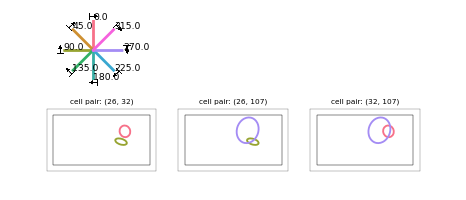

In [175]:
%matplotlib notebook
fig, axn = pl.subplots(1, 3, figsize=(7,3), dpi=100)
fig.patch.set_alpha(1)

for ax, cpair in zip(axn.flat, plot_pairs_int):

    pair_rfs = fits_rfs[fits_rfs.cell.isin(cpair)]
    plot_ori_hues = [ori_colordict[float(fits.loc[rid]['tested_theta'])] \
                     for rid in cpair]
    ax = rfutils.plot_rfs_to_screen_pretty(pair_rfs, sdf_rf, screen, 
                                   fit_roi_list=cpair, ax=ax, 
                                   roi_colors=plot_ori_hues, ellipse_lw=2)
    ax.set_title('cell pair: %s' % str(cpair))
pl.subplots_adjust(left=0.1, right=0.9, top=0.5, bottom=0.1)
ax = fig.add_axes([0.05, 0.6, 0.3, 0.3], polar=True)
    
pplot.polar_theta_legend(ax, ori_colors)
# n=8
# theta_radians = np.array([np.deg2rad(t) for t in tested_thetas])
# for (th, xv, yv, col) in zip(tested_thetas, theta_radians, np.ones((8,1)), ori_colors):
#     ax.plot([0, xv], [0, yv], color=col, lw=3)
#     ax.text(xv, yv, th)
#     ylim = 1#
#     ytick_lim = np.floor(ylim*10)/10.
#     pplot.polar_ticks_gratings(ax, ylim=ylim, ytick_lim=ytick_lim, n_yticks=0)
# ax.set_aspect(1)
# ax.get_xlim(), ax.get_ylim()


In [1260]:
np.linspace(0, 315, 8)

array([  0.,  45.,  90., 135., 180., 225., 270., 315.])

In [176]:
cols=['neuron_pair', 'pearsons', 'pref_dir_diff',
      'rf_distance', 'cortical_distance', 'area_overlap', 'perc_overlap']
DISTS[DISTS.neuron_pair.isin(plot_pairs)][cols]


neuron_pair  pearsons  pref_dir_diff  rf_distance  cortical_distance  \
256       26_32 -0.807103     -73.469388    12.011319         214.081649   
288      26_107  0.830651     176.326531    13.613623         377.007002   
465      32_107 -0.698827    -110.204082     9.915466         590.887959   

     area_overlap  perc_overlap  
256      0.000000      0.000000  
288      0.043425      0.389543  
465      0.134004      0.653518

In [177]:
dists_rfs = DISTS.dropna().copy()
highcc_lowrf = dists_rfs[(dists_rfs.pearsons>0.6) 
                       & (dists_rfs.area_overlap<0.25)].copy()
common_cells = np.union1d(highcc_lowrf['cell_1'].unique(), 
                          highcc_lowrf['cell_2'].unique())
curr_fits = fits_rfs.loc[common_cells].copy()
curr_fits[curr_fits.response_pref>=0.12]

response_pref  response_null  theta_pref      sigma  response_offset  \
4         0.172959       0.129669  183.673469  36.864296         0.005179   
24        0.269858       0.095624  352.653061  62.459001        -0.049711   
26        0.551882       0.427300   95.510204  36.299707        -0.058535   
32        0.318593       0.288468   22.040816  47.199392        -0.115543   
33        0.223780       0.208910  102.857143  48.008928        -0.075902   
55        0.159463       0.085702  352.653061  23.041673         0.045708   
64        0.147223       0.103968    0.000000  22.652102         0.024824   
65        0.154554       0.103043   51.428571  34.002162         0.014718   
79        0.123141       0.045747  117.551020  34.957753         0.020687   
96        0.228757       0.167774  279.183673  31.756610         0.005286   
107       0.508786       0.321121  271.836735  23.678657         0.140048   
117       0.320584       0.175150   14.693878  33.796000         0.044736   
124       0.229470       0.174574   73.469388  34.281948        -0.002537   
128       0.373400       0.292521  264.489796  26.798484         0.038773   
143       0.153317       0.139097  271.836735  48.668180        -0.052956   
151       0.134763       0.112829   88.163265  23.318309         0.015357   
166       0.403277       0.334549  264.489796  46.173499        -0.078521   

          asi       dsi  circvar_asi  circvar_dsi        r2  ...        fy  \
4    0.596462  0.148460     0.909986     0.616848  0.882558  ...  4.762491   
24   0.396666  0.660789     0.676650     0.828967  0.748920  ...  5.673961   
26   0.574597  0.144175     0.885154     0.526899  0.936844  ...  1.623986   
32   0.535644  0.110369     0.903828     0.522858  0.837694  ...  1.548306   
33   0.509676  0.067630     0.945327     0.610018  0.875279  ...  5.855004   
55   0.764775  0.374080     0.795748     0.605951  0.842111  ...  1.123534   
64   0.767878  0.253192     0.825099     0.494180  0.906646  ...  3.945027   
65   0.565531  0.225446     0.858543     0.671930  0.872054  ...  6.190255   
79   0.549366  0.457023     0.768254     0.715677  0.884246  ...  0.524642   
96   0.598155  0.143035     0.880823     0.517194  0.928404  ...  7.131686   
107  0.722566  0.218975     0.896235     0.689425  0.907295  ...  3.806510   
117  0.593381  0.342749     0.772646     0.614633  0.893698  ...  6.844137   
124  0.574262  0.140672     0.886760     0.545304  0.915657  ...  6.581287   
128  0.663668  0.111712     0.918535     0.530048  0.944413  ...  5.217545   
143  0.529505  0.112556     0.924929     0.661549  0.851809  ...  6.287650   
151  0.721257  0.088020     0.935409     0.495218  0.937946  ...  0.648557   
166  0.510404  0.130638     0.901659     0.624125  0.962524  ...  4.468042   

     ratio_xy  major_axis  minor_axis  anisotropy  aniso_index eccentricity  \
4    0.619074   17.609088   10.901323    0.235274     0.217738    21.006582   
24   0.845829   16.386815   13.860447    0.083524     0.073191    25.310728   
26   2.088792    5.521507    2.643397    0.352498    -0.145144    21.293372   
32   0.901093    5.425095    4.888513    0.052027     0.047699    27.121910   
33   1.247408   11.347705    9.097028    0.110086     0.003515    30.409997   
55   0.786007   11.777898    9.257510    0.119816     0.118724    26.351229   
64   0.906326    8.234817    7.463431    0.049138     0.037127    25.840305   
65   0.626454    7.811982    4.893844    0.229669     0.050525    27.233696   
79   1.225774    6.455172    5.266200    0.101436    -0.084948    20.132440   
96   1.173873    7.981914    6.799641    0.079983     0.062944    11.620690   
107  0.823562   12.066686    9.937668    0.096754     0.086874    18.830365   
117  1.275098    7.364427    5.775577    0.120917     0.103832    14.423485   
124  0.898242    7.043973    6.327193    0.053606    -0.015390    13.236032   
128  2.126893    7.689867    3.615540    0.360387     0.128656    13.753424   
143  1.636683    8.853114   

In [178]:
check_ = DISTS[(DISTS.perc_overlap>=0.8) 
                  & (DISTS.pearsons<-0.75)].copy()
curr_pairs = check_['neuron_pair'].values
check_pairs = [(int(v.split('_')[0]), int(v.split('_')[1])) for v in curr_pairs]
check_pairs

[(4, 26),
 (4, 93),
 (4, 99),
 (4, 107),
 (4, 128),
 (4, 143),
 (4, 154),
 (4, 166),
 (26, 55),
 (32, 33),
 (33, 64),
 (44, 65),
 (117, 143),
 (117, 154)]

In [179]:
%matplotlib notebook
for cpair in check_pairs:
    r1, r2 = cpair
    rid_colors={r1: 'r', r2: 'b'}
    cc, dist = check_[check_['neuron_pair']=='%s_%i' % (r1, r2)]\
                [['pearsons', 'perc_overlap']].values[0]
    t_=[]
    means_={}
    for rid in cpair:
        ckey = tuple(fits.loc[rid][['sf', 'size', 'speed']].values)
        cfgs_ = sorted([g for g, (sf, sz, sp) in \
                        sdf[['sf', 'size', 'speed']].iterrows() \
                        if tuple([sf, sz, sp])==ckey])
        tdf = traceutils.get_mean_and_std_traces(rid, processed, labels, 
                        cfgs_, sdf, return_stacked=True, smooth=True, win_size=7)
        tdf['cell'] = rid
        t_.append(tdf)
        meanr = trialmetrics[trialmetrics.config.isin(cfgs_)][[rid, 'config']]\
                        .groupby('config').mean()
        means_[rid] = meanr
    tdf = pd.concat(t_, axis=0).reset_index(drop=True)
    fg = sns.FacetGrid(data=tdf, col='ori', col_order=tested_thetas, 
                   height=2.4, aspect=0.5, hue='cell', palette=rid_colors)
    fg.map(pl.plot, 'time', 'mean', lw=1)
    pl.subplots_adjust(left=0.1, right=0.7, bottom=0.3, top=0.7)
    # Add fit
    ax = fg.fig.add_axes([0.7, 0.5, 0.25, 0.25], polar=True) #1, 9, 9, polar=True)
    for rid in cpair:
        thetas = osi.interp_values(tested_thetas, n_intervals=3, wrap_value=360)
        cpopt = tuple(fits.loc[rid][fit_params].values)       
        fitv = osi.double_gaussian( thetas, *cpopt)  
        meanr = means_[rid][rid].values
        if meanr.min()<0:
            meanr -= meanr.min()
        truv = np.array(osi.interp_values(meanr, n_intervals=3, wrap_value=meanr[-1]))
        _, ax = osi.polar_plot_roi(thetas, truv, curr_sems=None, response_type='dff', 
                                   fig=fg.fig, ax=ax, color=rid_colors[rid],
                                  linestyle=':')
        _, ax = osi.polar_plot_roi(thetas, fitv, curr_sems=None, response_type='dff', 
                                   fig=fg.fig, ax=ax, color=rid_colors[rid] )
    fg.fig.patch.set_alpha(1)
    fg.fig.text(0.01, 0.85, 'rid %i vs %i\n(cc=%.2f, D=%.2f)' % (r1, r2, cc, dist),
               fontsize=10)
    ax=fg.fig.axes[-2]
    leg_h = pplot.custom_legend_markers(colors=[rid_colors[r] for r in [r1,r2]],
                    labels=[r1, r2])
    ax.legend(handles=leg_h, bbox_to_anchor=(1,1), frameon=False, loc='upper left')

ValueError: Length of values (135) does not match length of index (137)

In [76]:
experiment='gratings'
session, animalid, fovnum = hutils.split_datakey_str(dk)
print(session, animalid, fovnum)

20190616 JC097 1


In [75]:
fitresults, fitparams = gutils.load_tuning_results(dk, fit_desc=ori_fit_desc, traceid=traceid)

g = CELLS[(CELLS.visual_area==va) & (CELLS.datakey==dk)]
g.shape
# Get OSI results
rois_ = g['cell'].unique()
boot_ = dict((k, v) for k, v in fitresults.items() if k in rois_)

In [97]:
dff_traces, labels, sdf = p3.load_traces(animalid, session, fovnum, experiment, 
                traceid=traceid, response_type=response_type,
                responsive_test=responsive_test, responsive_thr=responsive_thr,
                n_stds=n_stds)
dff_traces.head()

0         1         2         3         5         20        21   \
0 -0.059850 -0.076913 -0.025072 -0.126892 -0.325773 -0.077002  0.004512   
1 -0.054731  0.050644  0.015883  0.035610 -0.364852 -0.029520 -0.030707   
2 -0.109366  0.055954 -0.147544  0.077542 -0.336306 -0.005467  0.060920   
3 -0.000364 -0.038872 -0.068967 -0.050531 -0.323488  0.107175 -0.076053   
4 -0.081666  0.049524 -0.033229  0.032627 -0.396479  0.097282 -0.051746   

        22        25        34   ...       324       361       368       377  \
0 -0.023871  0.076139  0.047585  ...  0.114434  0.013686  0.016365  0.013910   
1 -0.099958 -0.004839  0.014009  ...  0.033311  0.029857 -0.022107  0.007870   
2  0.021564  0.018965 -0.000560  ... -0.043046  0.039188  0.119595  0.056234   
3 -0.006171  0.004742 -0.040840  ... -0.094900 -0.118847 -0.081478 -0.050011   
4 -0.145406  0.012701  0.047669  ...  0.049319 -0.049000 -0.020750  0.048310   

        390       396       399       428       430       435  
0  0.001983  0.048927 -0.023566  0.059044 -0.204925 -0.041495  
1 -0.037266  0.070846 -0.005736  0.046949 -0.210180 -0.077081  
2 -0.001522 -0.065982 -0.007820 -0.009689 -0.045336  0.025823  
3  0.046474  0.031842  0.000658 -0.021867  0.097392 -0.010926  
4  0.028206  0.021667  0.056593  0.125210 -0.035762 -0.031923  

[5 rows x 88 columns]

In [98]:
df_['response_pref'].max()

0.36979364541143567

In [99]:
windowsz = 9
smooth_traces = True
plot_trials = True

ymax = 0.2
min_val, max_val = 0, 0

trace_color = 'k'

transform_param = 'ori'
col_values = sorted(sdf[transform_param].unique())

In [100]:
cfg_values = [tuple(c) for c in fitparams['non_ori_configs']]
ori_colors = sns.color_palette(palette='dark_%s' % colormap, n_colors=len(col_values))
print(col_values)
print(cfg_values)
n_conds = len(cfg_values)

[0, 45, 90, 135, 180, 225, 270, 315]
[(0.1, 20.0, 10), (0.1, 20.0, 20), (0.1, 200.0, 10), (0.1, 200.0, 20), (0.5, 20.0, 10), (0.5, 20.0, 20), (0.5, 200.0, 10), (0.5, 200.0, 20)]


In [102]:
plot_rois = [155,262, 280, 399]
plot_roi_list=plot_rois
print(plot_rois)

[155, 262, 280, 399]


## Example polar

In [106]:
rid = 155
n_intervals_interp = 3
stimparam = cfg_values[0]
bootr = boot_[rid][stimparam]
thetas_interp = bootr['fits']['xv']
thetas = bootr['fits']['xv'][0::n_intervals_interp]

In [110]:
r2comb, gof, fitr = gutils.evaluate_fits(bootr, interp=True)
origr0 = bootr['data']['responses'].mean(axis=0).values
#origr = np.abs(origr0 - origr0.mean())
origr = (origr0 - origr0.min()) #- (origr0 - origr0.mean()).min()
origr = np.append(origr, origr[0]) # wrap back around
print(len(origr), len(fitr)) 

9 25


In [180]:
gof_thr=0.5
pass_gof = gdata[gdata['gof']>=gof_thr].copy()
best_ixs = pass_gof\
                .groupby(['visual_area', 'datakey', 'cell'])['response_pref']\
                .transform(max) == pass_gof['response_pref']
best_fits = pass_gof.loc[best_ixs].copy()
best_fits.head()

asi       dsi  response_null  response_offset  response_pref  \
2   0.590751  0.679958       0.009313        -0.001160       0.027233   
5   0.357954  0.742214       0.003853        -0.000182       0.033124   
6   0.060657  0.418246       0.000417        -0.025977       0.101769   
9   0.669880  0.416914       0.016238        -0.000277       0.029183   
11  0.392090  0.723005       0.008937        -0.003883       0.030799   

        sigma  theta_pref        r2   cell    r2comb       gof   sf  size  \
2   39.562740  352.653061  0.892822  172.0  0.899031  0.765403  0.1  60.0   
5   44.937365  257.142857  0.926326  187.0  0.922391  0.835984  0.1  60.0   
6   99.134356   95.510204  0.888896  190.0  0.904245  0.812975  0.1  60.0   
9   32.349965    0.000000  0.881019  216.0  0.644633  0.650666  0.1  60.0   
11  52.672152    0.000000  0.888877  220.0  0.819293  0.758257  0.1  60.0   

    speed visual_area              datakey animalid            fov   session  
2    10.0          Li  20190314_JC070_fov1    JC070  FOV1_zoom2p0x  20190314  
5    10.0          Li  20190314_JC070_fov1    JC070  FOV1_zoom2p0x  20190314  
6    10.0          Li  20190314_JC070_fov1    JC070  FOV1_zoom2p0x  20190314  
9    10.0          Li  20190314_JC070_fov1    JC070  FOV1_zoom2p0x  20190314  
11   10.0          Li  20190314_JC070_fov1    JC070  FOV1_zoom2p0x  20190314

In [193]:
currg = best_fits[(best_fits.visual_area==va) & (best_fits.datakey==dk)].copy()
#currg = currg0[currg0['gof']>=gof_thr]
npass_ = len(currg['cell'].unique())
nall_ = len(currg0['cell'].unique())
print(npass_, nall_)


34 74


In [114]:
importlib.reload(gutils)

<module 'utils.gratings_utils' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/utils/gratings_utils.py'>

In [182]:
currdata = NDATA[(NDATA.visual_area==va) & (NDATA.datakey==dk) & (NDATA['cell']==rid)].copy()
currdata.head()
# sdf = p3.get_stimuli(dk, 'gratings')
gratings_params=['ori', 'speed', 'sf', 'size']
for p in gratings_params:
    currdata[p] = sdf.loc[currdata['config']][p].values

In [199]:
# Add TF 
currg['tf'] = currg['sf']*currg['speed'] # fit params
currdata['tf'] = currdata['sf'] * currdata['speed'] # trial data
print(sorted(currdata['tf'].unique()))
currg.head()

[1.0, 2.0, 5.0, 10.0]


asi       dsi  response_null  response_offset  response_pref  \
2775  0.195308  0.571425       0.020930        -0.021574       0.090963   
2782  0.496438  0.252988       0.082878        -0.039848       0.102565   
2788  0.736206  0.119156       0.041650         0.007465       0.052532   
2799  0.552736  0.607409       0.030281        -0.001267       0.081455   
2804  0.213157  0.491717       0.019220        -0.023134       0.056257   

          sigma  theta_pref        r2  cell    r2comb       gof   sf   size  \
2775  74.579649  191.020408  0.853096   1.0  0.760906  0.660957  0.1  200.0   
2782  54.962971   88.163265  0.796958  22.0  0.710106  0.578380  0.5   20.0   
2788  22.501239  264.489796  0.897492  37.0  0.825375  0.763621  0.1  200.0   
2799  37.089249  279.183673  0.788202  52.0  0.698670  0.549860  0.1   20.0   
2804  86.467439  315.918367  0.774580  60.0  0.719698  0.521663  0.5   20.0   

      speed visual_area              datakey animalid            fov  \
2775   20.0          V1  20190617_JC097_fov1    JC097  FOV1_zoom2p0x   
2782   10.0          V1  20190617_JC097_fov1    JC097  FOV1_zoom2p0x   
2788   10.0          V1  20190617_JC097_fov1    JC097  FOV1_zoom2p0x   
2799   20.0          V1  20190617_JC097_fov1    JC097  FOV1_zoom2p0x   
2804   20.0          V1  20190617_JC097_fov1    JC097  FOV1_zoom2p0x   

       session    tf  
2775  20190617   2.0  
2782  20190617   5.0  
2788  20190617   1.0  
2799  20190617   2.0  
2804  20190617  10.0

In [204]:
pref_tf = round(float(currg[currg['cell']==rid]['tf']), 1)
pref_dir = float(currdata[currdata['tf']==pref_tf]['ori'].max())
print(pref_tf, pref_dir)

1.0 315.0


In [196]:
#curr_allg = pass_gof[(pass_gof.visual_area==va) & (pass_gof.datakey==dk)].copy()
#curr_allg[curr_allg['cell']==rid]

In [266]:
meanr = currdata.groupby(['ori', 'tf', 'size']).mean().reset_index()
meanr['ori_rad'] = [np.deg2rad(t) for t in meanr['ori']]

[  0.  45.  90. 135. 180. 225. 270. 315.]


<IPython.core.display.Javascript object>


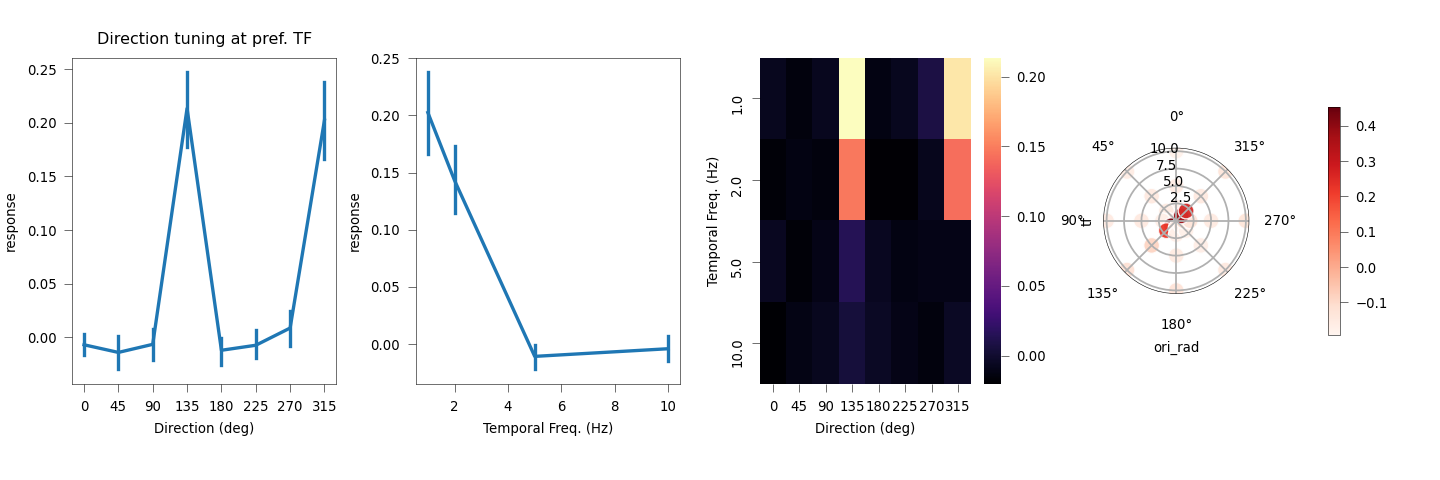

In [267]:
oris=np.linspace(0, 315, 8)
tfs = sorted(currdata['tf'].unique())
print(oris)
fig = pl.figure(figsize=(9,3))
#, axn = pl.subplots(1,3, figsize=(8,3))
# Direction tuning # preferred TF
ax=fig.add_subplot(141)
sns.lineplot(x='ori', y='response', data=currdata[currdata['tf']==pref_tf], ax=ax,
            err_style='bars')
ax.set_xticks(oris)
ax.set_xlabel('Direction (deg)')
ax.set_title('Direction tuning at pref. TF')

# TF tuning at preferred dir.
ax=fig.add_subplot(142)
sns.lineplot(x='tf', y='response', data=currdata[currdata['ori']==pref_dir], ax=ax,
            err_style='bars')
ax.set_xlabel('Temporal Freq. (Hz)')

# DIR-TF heatmap
ax=fig.add_subplot(143)
dir_tf_map = currdata[['ori', 'tf', 'response']]\
                .pivot_table(index='tf', columns='ori')
sns.heatmap(dir_tf_map.values, ax=ax, cmap='magma')
ax.set_xticklabels([int(i) for i in oris])
ax.set_xlabel('Direction (deg)')
ax.set_yticklabels([i for i in tfs])
ax.set_ylabel('Temporal Freq. (Hz)')

# Polar scatter
cmap='Reds'
norm = pl.Normalize(currdata['response'].min(), currdata['response'].max())
sm = pl.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

ax =fig.add_subplot(144, projection='polar')
sns.scatterplot(x="ori_rad", y="tf", hue="response", data=meanr, s=50,
      alpha=0.8, palette='Reds', ax=ax, legend=False) # vmin=0, vmax=0.1)
ax.set_theta_zero_location('N')
ax.figure.colorbar(sm, shrink=0.7, pad=0.3)

pl.subplots_adjust(left=0.05, right=0.95, wspace=0.3, bottom=0.2)

In [287]:
from mpl_toolkits.axes_grid1 import make_axes_locatable


<IPython.core.display.Javascript object>


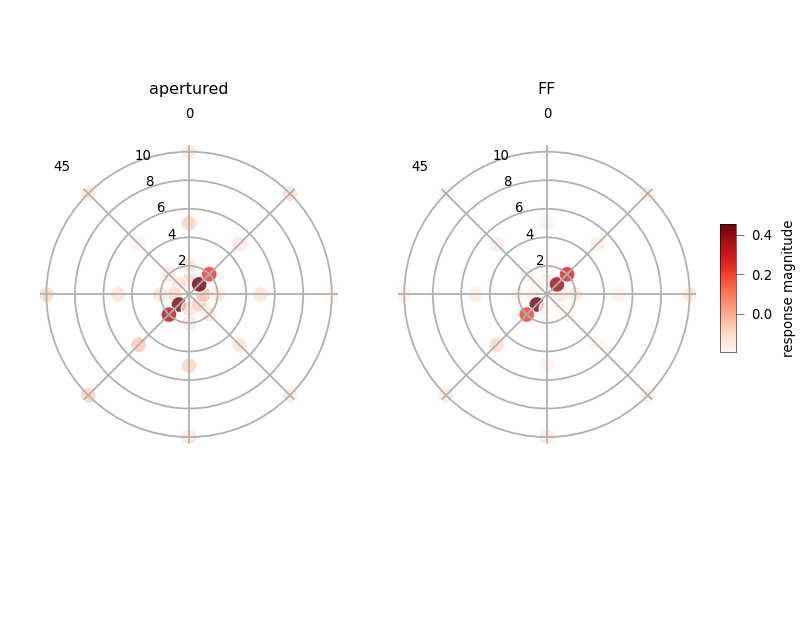

/n/coxfs01/2p-pipeline/envs/behavior3/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator


In [313]:
fig = pl.figure()

# Polar scatter
cmap='Reds'
vmin=currdata['response'].min()
vmax = currdata['response'].max()
norm = mpl.colors.Normalize(vmin, vmax)
sm = pl.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

ax =fig.add_subplot(121, projection='polar')
ax.set_title('apertured')
sns.scatterplot(x="ori_rad", y="tf", hue="response", data=meanr[meanr['size']<200], 
               s=50, alpha=0.8, palette='Reds', ax=ax, legend=False,
               vmin=vmin, vmax=vmax)

ax =fig.add_subplot(122, projection='polar')
ax.set_title('FF')
im=sns.scatterplot(x="ori_rad", y="tf", hue="response", data=meanr[meanr['size']==200], 
              s=50, alpha=0.8, palette='Reds', ax=ax, legend=False,
              vmin=vmin, vmax=vmax)
for ax in fig.axes:
    ax.set_theta_zero_location('N')
    ax.set_xticklabels([0, 45])
    ax.spines['polar'].set_visible(False)
    ax.set_ylabel('')
    ax.set_xlabel('')
    
#divider = make_axes_locatable(ax)
cax = fig.add_axes([0.9, 0.45, 0.02, 0.2])
#cbar.ax.set_title("response magnitude")
ax.figure.colorbar(sm, cax=cax, shrink=0.7, pad=0., label='response magnitude')

pl.subplots_adjust(left=0.05, right=0.87, wspace=0.2, bottom=0.2)

In [119]:
%matplotlib notebook

<IPython.core.display.Javascript object>


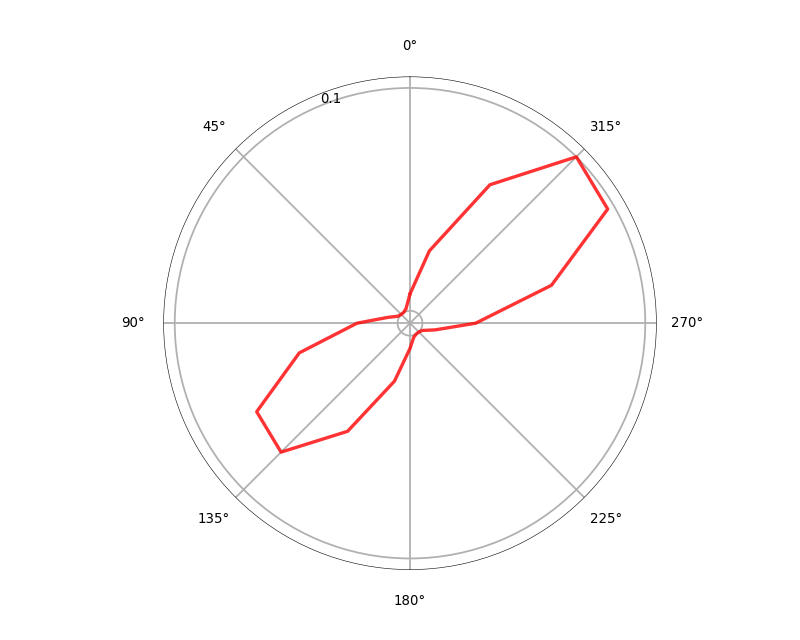

(<Figure size 500x400 with 1 Axes>, <PolarAxesSubplot:>)

In [120]:
fig = pl.figure()
ax =fig.add_subplot(projection='polar')
gutils.plot_tuning_polar_roi(thetas_interp, fitr, curr_sems=None, 
                response_type=response_type,
                fig=fig, ax=ax, color='r', linestyle='-', alpha=0.8,
                label='gof %.2f\ndff %.2f' % (gof, origr.max()) )

In [ ]:
thetas = np.array([np.deg2rad(c) for c in curr_oris])
radii = curr_resps.copy()


## Example traces

In [94]:
def temporal_downsample(trace, windowsz):
    tmp1=np.concatenate((np.ones(windowsz)*trace[0], trace, np.ones(windowsz)*trace[-1]),0)
    tmp2=np.convolve(tmp1, np.ones(windowsz)/windowsz, 'same')
    tmp2=tmp2[windowsz:-windowsz]
    return tmp2

<IPython.core.display.Javascript object>


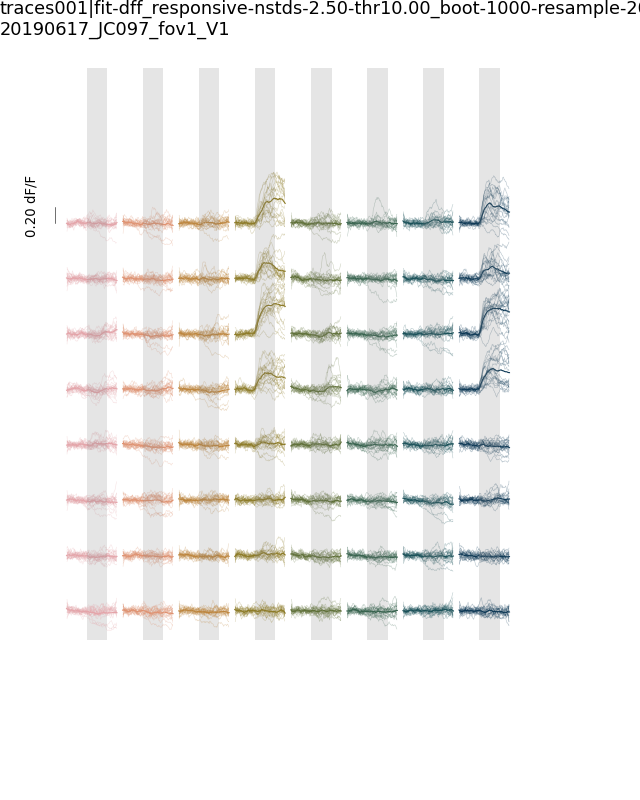

0 (0.1, 20.0, 10)
1 (0.1, 20.0, 20)
2 (0.1, 200.0, 10)
3 (0.1, 200.0, 20)
4 (0.5, 20.0, 10)
5 (0.5, 20.0, 20)
6 (0.5, 200.0, 10)
7 (0.5, 200.0, 20)
/n/coxfs01/julianarhee/aggregate-visual-areas/gratings-tuning/traces001-fit-dff_responsive-nstds-2.50-thr10.00_boot-1000-resample-20/aggregate_metrics traces__V1_20190617_JC097_fov1_rid155


<IPython.core.display.Javascript object>


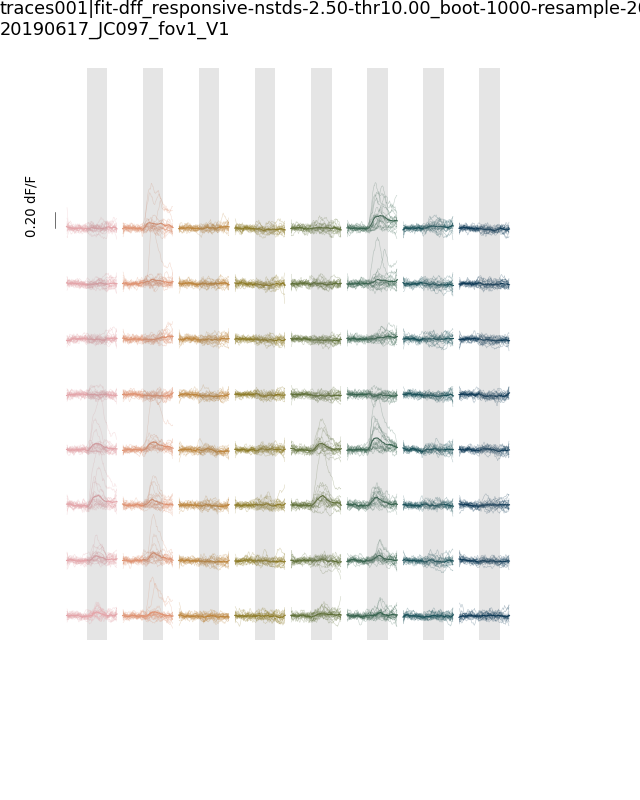

0 (0.1, 20.0, 10)
1 (0.1, 20.0, 20)
2 (0.1, 200.0, 10)
3 (0.1, 200.0, 20)
4 (0.5, 20.0, 10)
5 (0.5, 20.0, 20)
6 (0.5, 200.0, 10)
7 (0.5, 200.0, 20)
/n/coxfs01/julianarhee/aggregate-visual-areas/gratings-tuning/traces001-fit-dff_responsive-nstds-2.50-thr10.00_boot-1000-resample-20/aggregate_metrics traces__V1_20190617_JC097_fov1_rid262


<IPython.core.display.Javascript object>


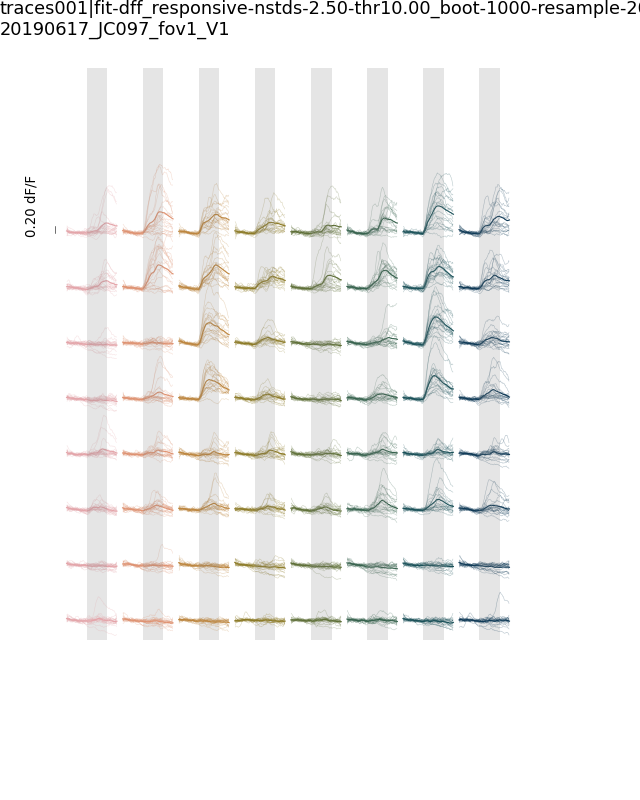

0 (0.1, 20.0, 10)
1 (0.1, 20.0, 20)
2 (0.1, 200.0, 10)
3 (0.1, 200.0, 20)
4 (0.5, 20.0, 10)
5 (0.5, 20.0, 20)
6 (0.5, 200.0, 10)
7 (0.5, 200.0, 20)
/n/coxfs01/julianarhee/aggregate-visual-areas/gratings-tuning/traces001-fit-dff_responsive-nstds-2.50-thr10.00_boot-1000-resample-20/aggregate_metrics traces__V1_20190617_JC097_fov1_rid280


<IPython.core.display.Javascript object>


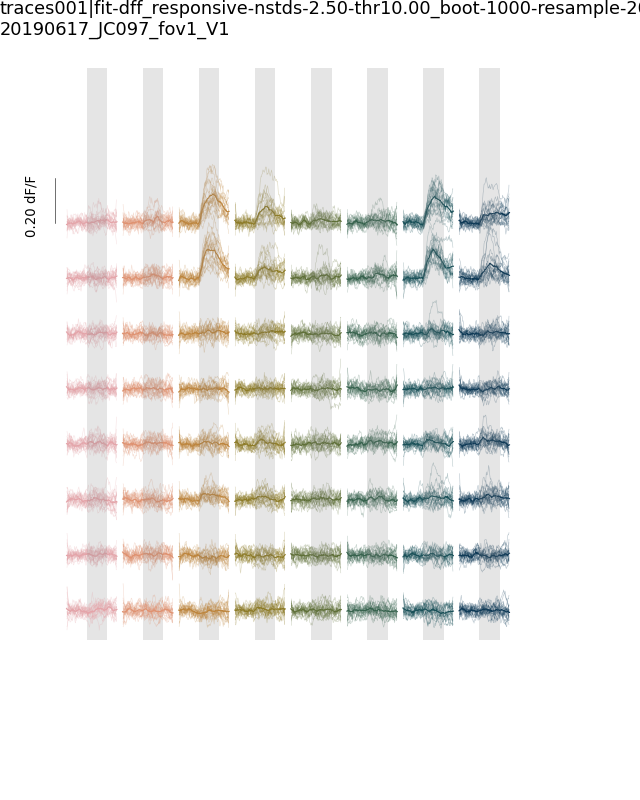

0 (0.1, 20.0, 10)
1 (0.1, 20.0, 20)
2 (0.1, 200.0, 10)
3 (0.1, 200.0, 20)
4 (0.5, 20.0, 10)
5 (0.5, 20.0, 20)
6 (0.5, 200.0, 10)
7 (0.5, 200.0, 20)
/n/coxfs01/julianarhee/aggregate-visual-areas/gratings-tuning/traces001-fit-dff_responsive-nstds-2.50-thr10.00_boot-1000-resample-20/aggregate_metrics traces__V1_20190617_JC097_fov1_rid399


In [218]:
fontsize=6
n_conds = len(cfg_values)
for rid in plot_roi_list:
    fig, axes = pl.subplots(len(cfg_values), len(col_values), 
                        figsize=(4,5), sharex=False, sharey=True)
    fig.patch.set(alpha=1)
    for ci, cfgv in enumerate(cfg_values):
        condkey = cfgv #tuple([float(i) for i in cfgv.split('-')[1::2]])
        if condkey not in list(boot_[rid].keys()):
            currcfgs = sdf[(sdf['sf']==condkey[0]) 
                         & (sdf['size']==condkey[1]) & (sdf['speed']==condkey[2])].index.tolist()
        else:
            currcfgs = boot_[rid][condkey]['stimulus_configs']
        currlabels = labels[labels['config'].isin(currcfgs)]
        si = cfg_values.index(condkey)
        print(si, condkey)
        for col, (cfg, g) in zip(ori_colors, currlabels.groupby(['config'])):
            currv = sdf[transform_param][cfg] #.copy()
            plot_ix = col_values.index(currv)
            ax = axes[ci, plot_ix]
            ax.patch.set(alpha=0)
            for trial, tdf in g.groupby(['trial']):
                tsec = tdf['tsec'].values
                tvals = dff_traces[rid][tdf.index].values
                st = temporal_downsample(tsec, windowsz) if smooth_traces else tsec
                sm = temporal_downsample(tvals, windowsz) if smooth_traces else tvals
                ax.plot(st, sm, color=col, alpha=0.3, lw=0.25)
            meantrace = np.nanmean(np.array([dff_traces[rid][gg.index] for trial, gg in g.groupby(['trial'])]), axis=0)
            sm = temporal_downsample(meantrace, windowsz) if smooth_traces else meantrace
            ax.plot(tsec, sm, color=col, alpha=1, lw=0.5)

    for ai, ax in enumerate(axes.flat):
        ax.tick_params(which='both', axis='both', length=0)
        if ai == 0:
            ax.set_yticks([0, ymax])
            ax.set_yticklabels(['', ''])
            ax.set_ylabel('%.2f dF/F' % ymax, fontsize=fontsize)
            sns.despine(trim=True, ax=ax, offset=4, bottom=True)
            ax.set_xticklabels([])
        else:
            sns.despine(trim=True, ax=ax, offset=4, left=True, bottom=True)
            ax.set_xticklabels([])
    for ci in range(len(col_values)):
        ax=axes[n_conds-1, ci]
        rect = pl.Rectangle((0,0), width=1, height=(n_conds-2)+fig.subplotpars.wspace,
                         transform=ax.get_xaxis_transform(), clip_on=False, zorder=0,
                         edgecolor="none", facecolor="gray", alpha=0.2, linewidth=0)
        ax.add_patch(rect)
    pl.subplots_adjust(top=0.8, bottom=0.2, left=0.1, right=0.8,hspace=-.4, wspace=0.01)

    pplot.label_figure(fig, curr_data_id)
    figname='traces__%s_%s_rid%i' % ( va, dk, rid) 
    pl.savefig(os.path.join(examples_dir, '%s.svg' % figname))
    print(examples_dir, figname)

In [70]:
cfg_values


[(0.1, 200.0, 20),
 (0.1, 20.0, 20),
 (0.1, 40.0, 20),
 (0.5, 200.0, 20),
 (0.5, 20.0, 20),
 (0.5, 40.0, 20)]

In [1288]:
curr_dst_dir

'/n/coxfs01/julianarhee/aggregate-visual-areas/gratings-tuning/traces001-fit-dff_responsive-nstds-2.50-thr10.00_boot-1000-resample-20/aggregate_metrics/examples'

In [270]:
def calculate_signal_correlations(tuning_):
    '''
    tuning_ (pd.DataFrame): nconds x nrois.
    Each entry is the mean response (across trials) for a given stim condition.
    '''
    # Calculate signal corrs
    corrs_ = {}
    rois_ = [i for i in tuning_.columns if p3.isnumber(i)]
    # Get unique pairs, then iterate thru and calculate pearson's CC
    for col_a, col_b in itertools.combinations(rois_, 2):
        corrs_['%i__%i' % (col_a, col_b)] = spstats.pearsonr(tuning_[col_a], tuning_[col_b])
    sigcorrs = pd.DataFrame.from_dict(corrs_, orient='index')
    sigcorrs.columns = ['PCC', 'p-value']
    sigcorrs['cell_1'] = [int(r.split('__')[0]) for r in sigcorrs.index]
    sigcorrs['cell_2'] = [int(r.split('__')[1]) for r in sigcorrs.index]
    
    return sigcorrs

In [275]:
trial_epoch='plushalf'
experiment='gratings'
NDATA = p3.get_aggregate_data(experiment, traceid=traceid, 
                      response_type=response_type, epoch=trial_epoch,
                      responsive_test=responsive_test, 
                      responsive_thr=responsive_thr, n_stds=n_stds)


old_rats = ['JC061', 'JC067', 'JC070', 'JC073']
NDATA = p3.split_datakey(NDATA)
NDATA = NDATA[~NDATA.animalid.isin(old_rats)]

/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 3 dsets
['gratings']
...loading: /n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/aggr_gratings_trialmeans_traces001_nstds-thr-10.00_dff_plushalf.pkl


In [277]:
NDATA[NDATA.visual_area=='Li']['datakey'].unique()

array(['20190522_JC089_fov1', '20190527_JC092_fov3',
       '20190602_JC091_fov1', '20190606_JC091_fov1',
       '20190607_JC091_fov1', '20190609_JC099_fov1',
       '20190612_JC099_fov1', '20190614_JC091_fov1',
       '20190617_JC099_fov1', '20191018_JC113_fov1',
       '20191105_JC117_fov1', '20191111_JC120_fov1'], dtype=object)

In [278]:
SDF={}
for (va, dk), g in NDATA.groupby(['visual_area', 'datakey']):
    sdf = p3.get_stimuli(dk, 'gratings')
    SDF[dk] = sdf

In [279]:
fullSDF = {}
for dk, sdf in SDF.items():
    subset = sdf[sdf['size']>50][['ori', 'sf', 'size', 'speed']].copy()
    if len(subset)==0:
        print(dk)
    fullSDF[dk] = subset #.append(subset)

In [280]:
apSDF={}
for dk, sdf in SDF.items():
    subset = sdf[sdf['size']<100][['ori', 'sf', 'size', 'speed']].copy()
    if len(subset)==0:
        print(dk)
    apSDF[dk] = subset #.append(subset)

20190522_JC089_fov1
20190527_JC092_fov3


### Signal corrs

In [282]:
curr_dst_dir = os.path.join(dst_dir, 'aggregate_metrics')
print(curr_dst_dir)

/n/coxfs01/julianarhee/aggregate-visual-areas/gratings-tuning/traces001-fit-dff_responsive-nstds-2.50-thr10.00_boot-1000-resample-20/aggregate_metrics


In [283]:
importlib.reload(p3)

<module 'py3utils' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/notebooks/response_stats/py3utils.py'>

In [284]:
NDATA['experiment'] = 'gratings'
posdf = NDATA[['visual_area', 'datakey', 'experiment', 'cell']].copy()\
        .drop_duplicates().reset_index(drop=True)
# Get ROI positions
posdf = p3.add_rf_positions(posdf)

Adding RF position info...


In [285]:
posdf.shape, posdf.dropna().shape

((1675, 13), (1675, 13))

In [323]:
selective_only=False
stimulus_type='allstim'

assert stimulus_type in ['fullscreen', 'apertured', 'allstim']

if stimulus_type=='fullscreen':
    SD = fullSDF.copy()
elif stimulus_type=='apertured':
    SD = apSDF.copy()
else:
    SD = SDF.copy()
    
roi_filter='gof%.2f' % gof_thr if selective_only else 'allcells'
print(roi_filter)

allcells


In [324]:
c_ = []
for (va, dk), ndf in NDATA.groupby(['visual_area', 'datakey']):
    rois_ = ndf['cell'].unique()
    if len(rois_)<2:
        continue
    if dk not in SD.keys():
        continue
    sdf = SD[dk].copy()
    cfgs = sdf.index.tolist()
    if len(cfgs)==0:
        continue
    ndf = ndf[(ndf.config.isin(cfgs))]
    # Reshape dataframe to ntrials x nrois
    trial_means0 = p3.stacked_neuraldf_to_unstacked(ndf)
    # Zscore trials
    cfgs_by_trial = trial_means0['config']
    if selective_only:
        curr_cells = passg[(passg.visual_area==va) & (passg.datakey==dk)]['cell'].unique()
        if len(curr_cells)<5:
            continue
    else:
        curr_cells = rois_
    trial_means = trial_means0[curr_cells].copy()
    zscored = p3.zscore_dataframe(trial_means)
    zscored['config'] = cfgs_by_trial
    # Get mean reposnse per condition
    tuning_ = zscored.groupby(['config']).mean().reset_index()
    sigcorrs = calculate_signal_correlations(tuning_)
    # Get current FOV rfdata and add position info to sigcorrs df
    pos_ = posdf[(posdf.visual_area==va) & (posdf.datakey==dk)].copy()
    assert len([r for r in rois_ if r not in pos_['cell'].values])==0, \
        "[%s, %s]: incorrect roi indexing in RFDATA" % (va, dk)
    pos_.index = pos_['cell'].values
    # Coords of cell1 in pair, in order
    coords1 = np.array(pos_.loc[sigcorrs['cell_1'].values][['ml_pos', 'ap_pos']])
    # Coords of cell2 in pair 
    coords2 = np.array(pos_.loc[sigcorrs['cell_2'].values][['ml_pos', 'ap_pos']])
    # Get dists, in order of appearance
    dists = [np.linalg.norm(c1-c2) for c1, c2 in zip(coords1, coords2)]
    sigcorrs['cortical_distance'] = dists
    sigcorrs['visual_area'] = va
    sigcorrs['datakey'] = dk
    c_.append(sigcorrs)
signal_corrs = pd.concat(c_, axis=0).reset_index(drop=True)


In [325]:
# Bin cortical distances for plotting
n_bins_dist = 10
n_bins_overlap = 8
use_quartile=False
bin_type = 'eqpop%i' % n_bins_dist if use_quartile else 'eqwidth%i' % n_bins_dist
print("binning: %s" % bin_type)

if use_quartile:
    signal_corrs['binned_dist'], bin_edges = pd.qcut(signal_corrs['cortical_distance'], \
                                    n_bins_dist, labels=False, retbins=True)
    #roi_df['binned_overlap'] = pd.cut(roi_df['perc_overlap'], n_bins_overlap, labels=False)
else:
    signal_corrs['binned_dist'], bin_edges = pd.cut(signal_corrs['cortical_distance'], \
                                     n_bins_dist,labels=False, retbins=True)
    #roi_df['binned_overlap'] = pd.cut(roi_df['perc_overlap'], n_bins_overlap, labels=False

binning: eqwidth10


In [326]:
min_n_pairs=10
counts_per_bin = signal_corrs.groupby(['visual_area', 'datakey', 'binned_dist'])\
                    ['PCC'].count().reset_index()
pass_keys = [(va, dk) for (va, dk), g in \
             counts_per_bin[counts_per_bin['PCC']>=min_n_pairs].groupby(['visual_area', 'datakey'])]
CC = pd.concat([g for (va, dk), g in signal_corrs.groupby(['visual_area', 'datakey']) \
               if (va, dk) in pass_keys])
CC.shape, signal_corrs.shape

((90940, 8), (90995, 8))

In [327]:
mean_ccs = CC.groupby(['visual_area', 'datakey', 'binned_dist']).mean().reset_index()

<IPython.core.display.Javascript object>


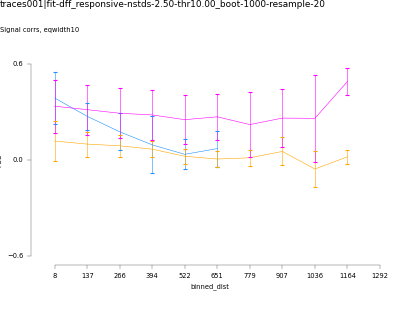

/n/coxfs01/julianarhee/aggregate-visual-areas/gratings-tuning/traces001-fit-dff_responsive-nstds-2.50-thr10.00_boot-1000-resample-20/aggregate_metrics sigcorrs_by_dist__allstim_allcells


In [329]:
lw=0.5
metric='PCC'
fig, ax = pl.subplots( figsize=(5,4)) #, sharex=True, sharey=False)
sns.lineplot(x='binned_dist', y=metric, data=mean_ccs, ax=ax,
             hue='visual_area', palette=area_colors, 
             ci='sd', err_style='bars', 
            err_kws={'capsize':2, 'lw': lw}, lw=lw)
ax.set_xticks(list(range(len(bin_edges))))
ax.set_xticklabels([round(i) for i in bin_edges])
ax.set_ylim([-0.6, 0.6])
ax.set_yticks(np.linspace(-0.6, 0.6, 3)) #([-0.6, 0.6])

sns.despine(offset=8, trim=True, ax=ax)
ax.legend_.remove()
pl.subplots_adjust(top=0.8, left=0.1, right=0.95, bottom=0.2, wspace=0.5, hspace=0.5)

p3.label_figure(fig, data_id)
fig.text(0, 0.9, 'Signal corrs, %s' % bin_type)
figname = 'sigcorrs_by_dist__%s_%s' % (stimulus_type, roi_filter)
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
print(curr_dst_dir, figname)

# Compare with RFs

In [1]:
# Load RF data
do_spherical_correction=False
rf_fit_desc = rfutils.get_fit_desc(response_type=response_type, 
                                   do_spherical_correction=do_spherical_correction)
rf_meta = sdata[sdata.experiment.isin(['rfs', 'rfs10'])].copy()
rfdata = rfutils.aggregate_rfdata(rf_meta, CELLS, fit_desc=rf_fit_desc)
# Get ROI positions
rfdata = p3.add_rf_positions(rfdata)
rf_dkeys = [(va, dk) for (va, dk), g in rf_meta.groupby(['visual_area', 'datakey'])]
rfCELLS = pd.concat([g for (va, dk), g in cells0.groupby(['visual_area', 'datakey'])\
                                  if (va, dk) in rf_dkeys])

NameError: name 'aggr' is not defined

In [323]:
combined_rfs = rfutils.average_rfs_select(rfdata)
df_ = []
for (va, dk), g in combined_rfs.groupby(['visual_area', 'datakey']):
    if va=='Lm':
        d_ = g[g.experiment.isin(['average_rfs', 'rfs'])]
    elif va=='Li':
        d_ = g[g.experiment.isin(['average_rfs', 'rfs10'])]
    else:
        d_ = g.copy()
    df_.append(d_)
rfdf = pd.concat(df_)


In [325]:
RFS=[]
GFS=[]
for (va, dk), gr_ in bestg.groupby(['visual_area', 'datakey']):
    rfs_ = rfdf[(rfdf['visual_area']==va) & (rfdf['datakey']==dk)].copy()
    if len(rfs_)==0:
        continue
    rf_cells = rfs_['cell'].unique()
    gr_cells = gr_['cell'].unique()
    common_cells = np.intersect1d(rf_cells, gr_cells)
    print('%s: %i cells in common (%s)' % (va, len(common_cells), dk))
    RFS.append(rfs_[rfs_['cell'].isin(common_cells)])
    GFS.append(gr_[gr_['cell'].isin(common_cells)])
    
RFS = pd.concat(RFS, axis=0).reset_index(drop=True)
GFS = pd.concat(GFS, axis=0).reset_index(drop=True)
print(GFS.shape, RFS.shape)
cols_to_use = RFS.columns.difference(GFS.columns)
DF = pd.merge(GFS, RFS[cols_to_use], left_index=True, right_index=True, how='outer')
print(DF['theta'].min(), DF['theta'].max())
DF['theta_deg'] = np.rad2deg(DF['theta_Mm_c'])
print(DF['theta_deg'].min(), DF['theta_deg'].max())
DF.dropna().groupby(['visual_area']).count()

Li: 0 cells in common (20190522_JC089_fov1)
Li: 5 cells in common (20190527_JC092_fov3)
Li: 35 cells in common (20190602_JC091_fov1)
Li: 6 cells in common (20190606_JC091_fov1)
Li: 9 cells in common (20190607_JC091_fov1)
Li: 1 cells in common (20190609_JC099_fov1)
Li: 3 cells in common (20190612_JC099_fov1)
Li: 14 cells in common (20190614_JC091_fov1)
Li: 1 cells in common (20190617_JC099_fov1)
Li: 4 cells in common (20191018_JC113_fov1)
Li: 0 cells in common (20191105_JC117_fov1)
Li: 0 cells in common (20191111_JC120_fov1)
Lm: 25 cells in common (20190512_JC083_fov1)
Lm: 19 cells in common (20190513_JC078_fov1)
Lm: 4 cells in common (20190517_JC083_fov1)
Lm: 23 cells in common (20190525_JC084_fov1)
Lm: 27 cells in common (20190603_JC080_fov1)
Lm: 3 cells in common (20190618_JC097_fov1)
Lm: 5 cells in common (20190627_JC091_fov1)
V1: 41 cells in common (20190511_JC083_fov1)
V1: 5 cells in common (20190512_JC083_fov1)
V1: 1 cells in common (20190517_JC083_fov1)
V1: 80 cells in common (2

asi  dsi  response_null  response_offset  response_pref  sigma  \
visual_area                                                                   
Li            78   78             78               78             78     78   
Lm           106  106            106              106            106    106   
V1           290  290            290              290            290    290   

             theta_pref   r2  cell  r2comb  ...  std_avg  std_x  std_y  theta  \
visual_area                                 ...                                 
Li                   78   78    78      78  ...       78     78     78     78   
Lm                  106  106   106     106  ...      106    106    106    106   
V1                  290  290   290     290  ...      290    290    290    290   

             theta_Mm_c  theta_Mm_deg  theta_c   x0   y0  theta_deg  
visual_area                                                          
Li                   78            78       78   78   78         78  
Lm                  106           106      106  106  106        106  
V1                  290           290      290  290  290        290  

[3 rows x 48 columns]

In [326]:
#gd =gdata[~gdata['animalid'].isin(old_rats)].copy()
GFS[GFS['visual_area']=='V1'].shape, GFS[GFS['visual_area']=='V1'].dropna().shape

((290, 20), (290, 20))

In [327]:
DF[DF['visual_area']=='V1'].shape, DF[DF['visual_area']=='V1'].dropna().shape

((290, 49), (290, 49))

In [344]:
counts_by_fov = DF[DF['gof']>=0.25].dropna().groupby(['visual_area', 'datakey']).count().reset_index()
counts_by_fov = p3.split_datakey(counts_by_fov)

In [345]:
overall_best = p3.select_best_fovs(counts_by_fov)
overall_best.groupby(['visual_area']).sum()
overall_dkeys = list(tuple(k) for k in overall_best[['visual_area', 'datakey']].values)

finaldf = pd.concat([g for (va,dk), g in DF.groupby(['visual_area', 'datakey'])\
                    if (va, dk) in overall_dkeys])

In [346]:
finaldf.dropna().groupby(['visual_area']).count()

asi  dsi  response_null  response_offset  response_pref  sigma  \
visual_area                                                                   
Li            61   61             61               61             61     61   
Lm           102  102            102              102            102    102   
V1           289  289            289              289            289    289   

             theta_pref   r2  cell  r2comb  ...  std_avg  std_x  std_y  theta  \
visual_area                                 ...                                 
Li                   61   61    61      61  ...       61     61     61     61   
Lm                  102  102   102     102  ...      102    102    102    102   
V1                  289  289   289     289  ...      289    289    289    289   

             theta_Mm_c  theta_Mm_deg  theta_c   x0   y0  theta_deg  
visual_area                                                          
Li                   61            61       61   61   61         61  
Lm                  102           102      102  102  102        102  
V1                  289           289      289  289  289        289  

[3 rows x 48 columns]

In [347]:
finaldf[finaldf['gof']>=0.].groupby(['visual_area']).count()

asi  dsi  response_null  response_offset  response_pref  sigma  \
visual_area                                                                   
Li            61   61             61               61             61     61   
Lm           102  102            102              102            102    102   
V1           289  289            289              289            289    289   

             theta_pref   r2  cell  r2comb  ...  std_avg  std_x  std_y  theta  \
visual_area                                 ...                                 
Li                   61   61    61      61  ...       61     61     61     61   
Lm                  102  102   102     102  ...      102    102    102    102   
V1                  289  289   289     289  ...      289    289    289    289   

             theta_Mm_c  theta_Mm_deg  theta_c   x0   y0  theta_deg  
visual_area                                                          
Li                   61            61       61   61   61         61  
Lm                  102           102      102  102  102        102  
V1                  289           289      289  289  289        289  

[3 rows x 48 columns]

In [348]:
importlib.reload(pplot)

<module 'plotting' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/notebooks/response_stats/plotting.py'>

<IPython.core.display.Javascript object>


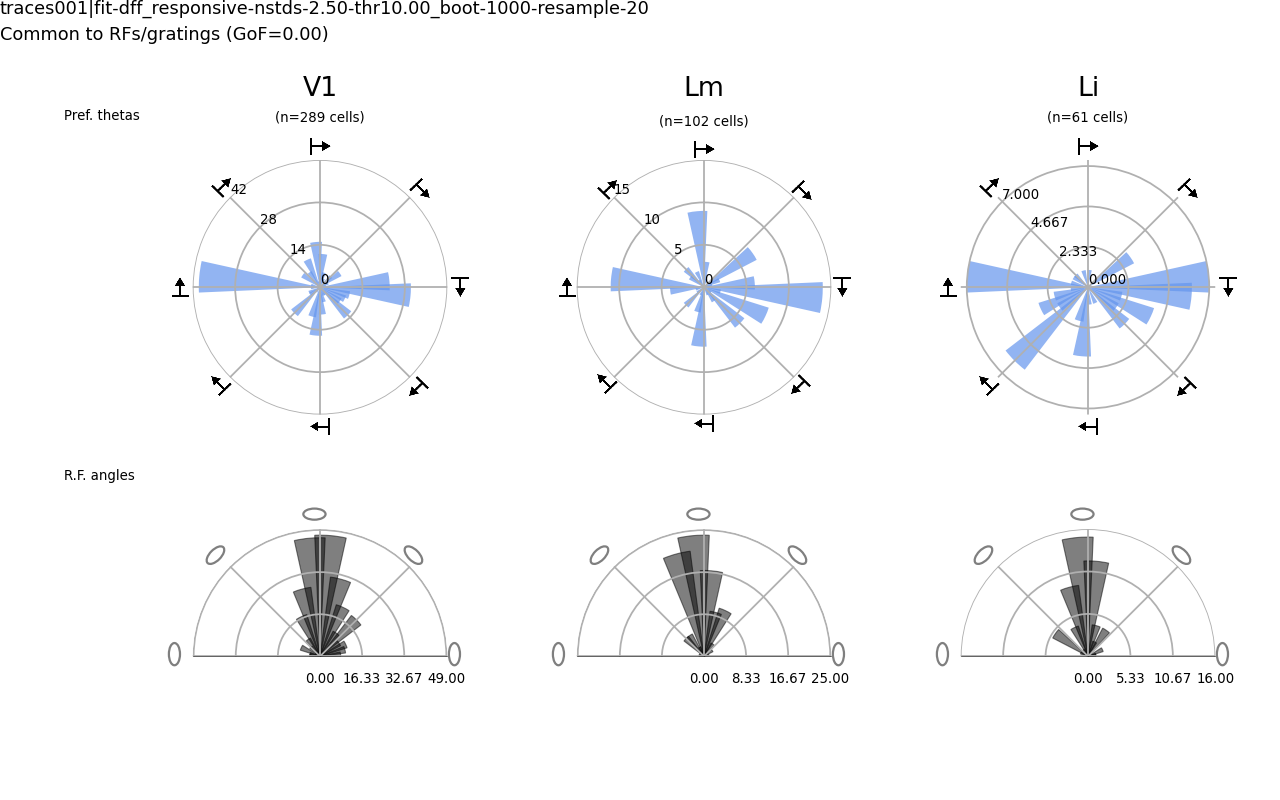

/n/coxfs01/julianarhee/aggregate-visual-areas/gratings-tuning/traces001-fit-dff_responsive-nstds-2.50-thr10.00_boot-1000-resample-20/aggregate_metrics polar_theta_v_RFangles__gof0.00_drop_repeats


In [363]:
gof_thr=0.0

plotd = finaldf[finaldf['gof']>=gof_thr].copy().dropna()
rf_color='k'
ori_color='cornflowerblue'
ell_icon_height = 5
alpha=0.5

bar_width=15.
bin_size = 10

max_ori = 360.
ori_bins = np.arange(0, max_ori+bin_size, bin_size)
rf_bins = np.arange(-90, 90+bin_size, bin_size)

rf_names = np.arange(-90, 90+45, 45)
ori_names = np.arange(0, max_ori+45, 45)

fig = pl.figure(figsize=(8,5))
i=0
for vi, visual_area in enumerate(visual_areas):
    g = plotd[plotd['visual_area']==visual_area].copy()
    # First, do PREFERRED THETA
    # --------------------------------------------------------------------
    degrees = g['theta_pref'].values % max_ori #% 180.
    radians = np.rad2deg(degrees)
    bin_counts, bin_vals = np.histogram(degrees, bins=ori_bins)
    centers = np.deg2rad(np.ediff1d(bin_vals)//2 + bin_vals[:-1])
    ax = pl.subplot(2, 3, vi+1, projection='polar')
    ax.bar(centers, bin_counts, width=np.deg2rad(bar_width), bottom=0.0, 
               facecolor=ori_color, alpha=0.7, edgecolor="none", 
               color=ori_color, linewidth=0.5)
    ax.set_title('%s' % (visual_area), loc='center', fontsize=12, y=1.2)
    ax.text(ax.get_xlim()[0], ax.get_ylim()[-1]*1.3, 
            '(n=%i cells)' % g.shape[0], fontsize=6, horizontalalignment='center')
    # Set ticks
    # ---------------------------------------------------------------------
    ax.set_theta_zero_location("N")
    ax.set_rlabel_position(45)
    ori_names = np.arange(0, 360, 45) #np.rad2deg(xticks)
    pplot.replace_ori_labels(ori_names, ax=ax, 
                    xybox=(0, 0), yloc=ax.get_ylim()[-1]*1.1, zoom=0.12, polar=True)
    ax.set_yticks(np.linspace(0, round(ax.get_ylim()[-1]), 4))
    #ax.set_yticklabels([])
    # Now, do RECEPTIVE FIELD angles
    # ---------------------------------------------------------------------
    degrees = np.rad2deg(g['theta_Mm_c'].values) #. #- 90.
    bin_counts, bin_vals = np.histogram(degrees, bins=rf_bins)
    centers = np.deg2rad(np.ediff1d(bin_vals)//2 + bin_vals[:-1])
    ax = pl.subplot(2, 3, vi+3+1, projection='polar')
    ax.bar(centers, bin_counts, width=np.deg2rad(bar_width), bottom=0.0, 
           color=rf_color, alpha=0.5, edgecolor=rf_color, lw=0.5)
    ax.set_theta_zero_location("N")
    # Set ticks
    # ---------------------------------------------------------------------
    ax.set_xlim([-np.pi/2., np.pi/2.])
    ax.set_xticks(np.arange(-np.pi/2., np.pi/2. + (np.pi/4.), np.pi/4.))
    ax.set_yticks(np.linspace(0, round(ax.get_ylim()[-1]), 4))
    #ax.set_yticklabels([])
    yloc = ax.get_ylim()[-1]*1.1 # + 4
    pplot.replace_rf_labels(rf_names, ax=ax, alpha=alpha,
                    width=ell_icon_height*2., height=ell_icon_height, color='k', 
                    yloc=yloc, lw=1, box_alignment=(1, 1), 
                    xybox=(-ell_icon_height/2., 1))
    i+=2
pplot.label_figure(fig, data_id)
pl.subplots_adjust(left=0.15, wspace=0.5, hspace=0.2, top=0.8,
                   right=0.95, bottom=0.1)

fig.text(0.05, 0.85, "Pref. thetas", horizontalalignment='left', fontsize=6)
fig.text(0.05, 0.4, "R.F. angles", horizontalalignment='left', fontsize=6)
fig.text(0.0, 0.95, "Common to RFs/gratings (GoF=%.2f)" % gof_thr, 
             horizontalalignment='left', fontsize=8)

figname = 'polar_theta_v_RFangles__gof%.2f_%s' % (gof_thr, dset_str)
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
print(curr_dst_dir, figname)

In [350]:
def split_by_angle(df_, bin_value, metric='theta_Mm_deg', boundary_value=180, bin_size=45, combine_zero=True):
    
    ori_bins = np.arange(-boundary_value, boundary_value+bin_size, bin_size)
        
    #angles = (degs + 180.) % (2*180.) - 180.
    half_bin = bin_size/2.

    if bin_value == -boundary_value:
        bmin = boundary_value - half_bin # 90 - 22.5
        bmax = -boundary_value + half_bin  # -90 + 22.5 
        if combine_zero:
            curr_vs = df_[ (df_[metric] >= bmin) | (df_[metric] <= bmax) ]
            #n_in_bin = len(angles[(angles >= bmin) | (angles<=bmax)])
        else:
            curr_vs = df_[df_[metric]<=bmax]
            #n_in_bin = len(angles[angles<=bmax])
    elif bin_value == boundary_value:
        bmin = boundary_value - half_bin
        bmax = -boundary_value + half_bin
        if combine_zero:
            curr_vs = df_[ (df_[metric] >= bmin) | (df_[metric] <= bmax) ]
            #n_in_bin = len(angles[(angles >= bmin) | (angles<=bmax)])
        else:
            curr_vs = df_[df_[metric] >= bmin]
            #n_in_bin = len(angles[angles>=bmin])
    else:
        bmin = bin_value - half_bin
        bmax = bin_value + half_bin
        curr_vs = df_[ (df_[metric] >= bmin) & (df_[metric] <= bmax) ]
        #n_in_bin = len(angles[(angles >= bmin) & (angles<=bmax)])

    #n_in_bin = np.where([angles<])
    #bin_counts.append(n_in_bin)

    return curr_vs #bin_counts, ori_bins

In [351]:
importlib.reload(pplot)

<module 'plotting' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/notebooks/response_stats/plotting.py'>

In [352]:
DF.groupby(['visual_area']).count()

asi  dsi  response_null  response_offset  response_pref  sigma  \
visual_area                                                                   
Li            78   78             78               78             78     78   
Lm           106  106            106              106            106    106   
V1           290  290            290              290            290    290   

             theta_pref   r2  cell  r2comb  ...  std_avg  std_x  std_y  theta  \
visual_area                                 ...                                 
Li                   78   78    78      78  ...       78     78     78     78   
Lm                  106  106   106     106  ...      106    106    106    106   
V1                  290  290   290     290  ...      290    290    290    290   

             theta_Mm_c  theta_Mm_deg  theta_c   x0   y0  theta_deg  
visual_area                                                          
Li                   78            78       78   78   78         78  
Lm                  106           106      106  106  106        106  
V1                  290           290      290  290  290        290  

[3 rows x 48 columns]

<IPython.core.display.Javascript object>


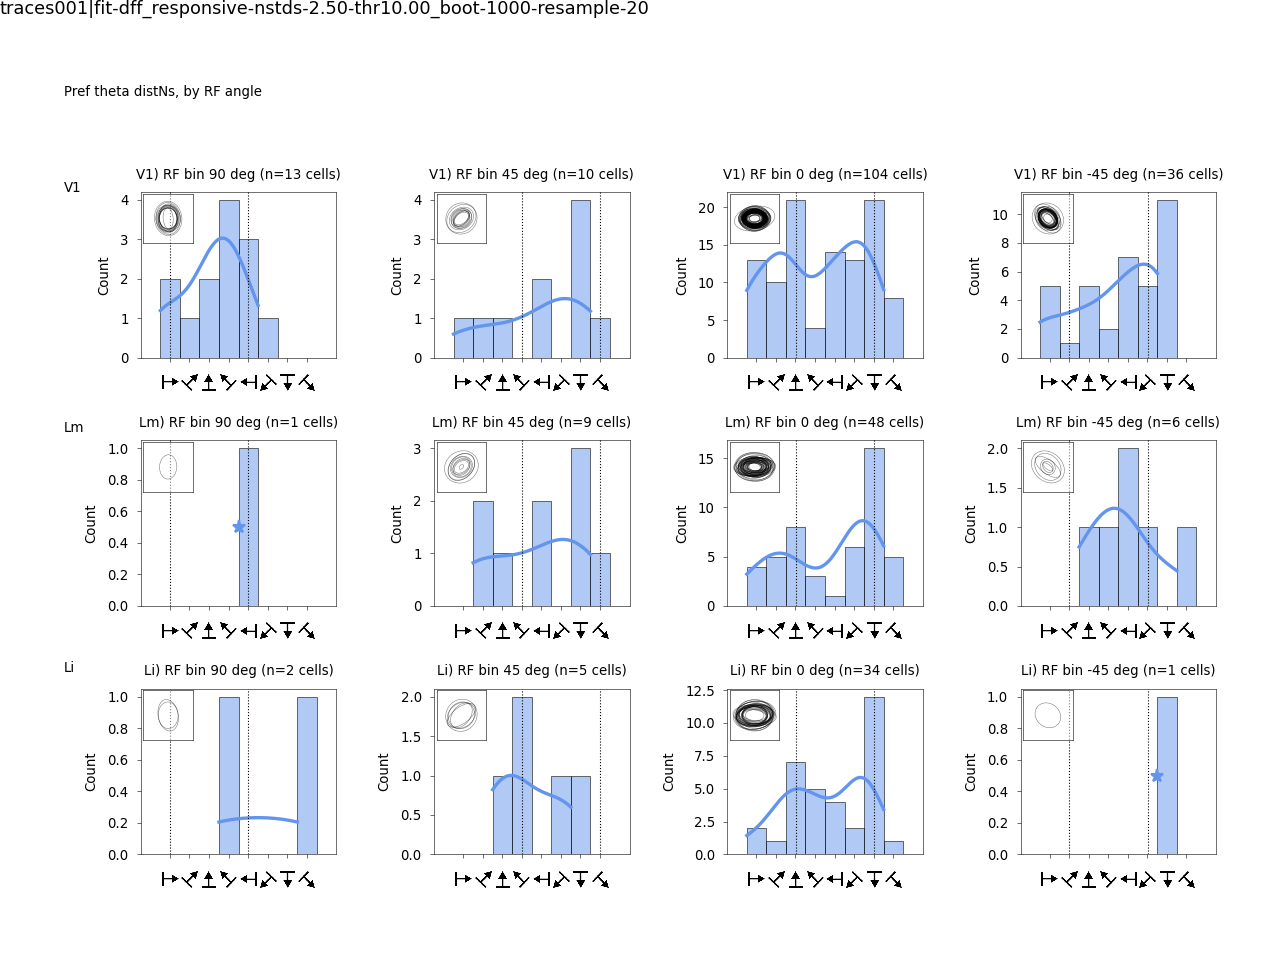

Li:: 78 cells


/n/coxfs01/2p-pipeline/envs/behavior3/lib/python3.7/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/n/coxfs01/2p-pipeline/envs/behavior3/lib/python3.7/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


Lm:: 106 cells
V1:: 290 cells
/n/coxfs01/julianarhee/aggregate-visual-areas/gratings-tuning/traces001-fit-dff_responsive-nstds-2.50-thr10.00_boot-1000-resample-20/aggregate_metrics hist_RFangle_vs_preferredtheta_gof0.00_drop_repeats


In [364]:
rf_color='k'
ori_color='cornflowerblue'

plotd = DF.copy()
yloc=0.5
rf_bin_size = 45
rf_boundary_value = 90 #np.pi/2.
rf_bins = np.arange(-rf_boundary_value, rf_boundary_value + rf_bin_size, rf_bin_size) #% 180.
rf_bin_span=22.5 #22.5 #.5 #22.5
rf_theta_param = 'theta_deg'
##### 
bar_width=30
ori_bin_span=22.5 #2.5 #22.5 #22.5
####
aniso_thr=0.1
filter_aniso=False
max_ori=360.
mod_val=360.
n_bins_dist = 8 if max_ori==360. else 4
ori_bins = np.arange(-180, 180+45, 45)
ori_names = np.arange(0, max_ori+45, 45)
label_unit='degrees'
# =====================================================
# PLOT
# =====================================================
fig, axn = pl.subplots(3, len(rf_bins)-1, figsize=(8,6),sharex=True)
pl.subplots_adjust(wspace=0.5, hspace=0.5, top=0.8, left=0.11, right=0.95)
offset=0.25
for va, df_ in plotd.groupby(['visual_area']):
    vi = visual_areas.index(va) #vi, va in enumerate(visual_areas):
    #df_ = DF[(DF['visual_area']==va)].copy()
    print('%s:: %i cells' % (va, df_.shape[0]))
    if filter_aniso:
        df_ = df_[df_['anisotropy']>=aniso_thr] #.copy()
    for ci, currbin in enumerate(rf_bins[::-1][0:-1]):   
        # Get all cells with RF angle CURRBIN
        # ---------------------------------------------------------------------
        curr_vs = split_by_angle(df_, currbin, metric=rf_theta_param, boundary_value=rf_boundary_value, 
                                 bin_size=rf_bin_span, combine_zero=True)
        if curr_vs.shape[0]==0:
            continue   
        ncells = curr_vs.shape[0]
        # Calculate distn of prefered OSI 
        # ---------------------------------------------------------------------
        pref_theta_deg = curr_vs['tested_theta'].values % mod_val
        # RF hists of value
        # ---------------------------------------------------------------------
        ax=axn[vi, ci]
        ax.set_title("%s (%i, %i)" % (va, vi, ci))        
        xticks = np.arange(0, mod_val+45, 45)
        if len(pref_theta_deg)==1:
            ax.plot(pref_theta_deg, yloc, color=ori_color, marker='*')
        #ax.hist(pref_theta_deg % mod_val, bins=xticks, align='mid', color='gray', alpha=0.5)
        sns.histplot(pref_theta_deg, ax=ax, bins=n_bins_dist, color=ori_color,
                    kde=True, stat='count', lw=.25, binrange=(0, 360))
#                     discrete=True) #$, ax=ax)
        #cnts, edges = np.histogram(pref_theta_deg, bins=8)
        #bwidth = np.mean(np.diff(edges))/2.
        #most_thetas = edges[cnts.argmax()] +bwidth
        #ax.plot(most_thetas, 0, color='r', marker='^')
        bwidth = np.mean(np.ediff1d(xticks))/2.
        line_loc = ((currbin+90)%360)+bwidth
        ax.axvline(x=line_loc, color='k', lw=0.5, ls=':')
        ax.axvline(x=(line_loc+180)%360., color='k', lw=0.5, ls=':')
        centers = np.ediff1d(xticks)//2 + xticks[:-1]
        ax.set_xticks(centers)
        #ax.set_xticklabels([int(i) for i in xticks], fontsize=4)
        pplot.replace_ori_labels(xticks, bin_centers=centers, ax=ax, xybox=(0, -0.1), 
                           yloc=-0.15, zoom=0.1, polar=False)
        ax.tick_params(which='both', axis='both', labelsize=6, size=2)
        # RF shapes
        # ---------------------------------------------------------------------
        rect = [0.0, 0.69, 0.28, 0.3]
        ax1 = pplot.add_subplot_axes(ax, rect, axisbg='white', axis_alpha=0.5)
        ax1.set_xlim([-12, 12])
        ax1.set_ylim([-12, 12])
        mean_rf_theta = np.rad2deg(np.mean(abs(curr_vs['theta_Mm_c'].values)))
        for ri in curr_vs.index.tolist():
            rv = curr_vs.loc[ri]
            (sz_x, sz_y, th) = rv[['major_axis', 'minor_axis', 'theta_Mm_c']].values
            #(sz_x, sz_y, th) = rv[['std_x', 'std_y', 'theta']].values
            ell = mpl.patches.Ellipse((0, 0), abs(sz_x), abs(sz_y), angle=np.rad2deg(th), edgecolor=rf_color, 
                          facecolor='none', alpha=0.5, lw=0.25)
            ax1.add_patch(ell)
        ax1.set_aspect('equal')
        #ax1.set_title('avg. RF=%.1f deg' % (mean_rf_theta), loc='center', fontsize=6)
        pplot.turn_off_axis_ticks(ax1, despine=False)
        ax.set_title('%s) RF bin %i deg (n=%i cells)' % (va, currbin, ncells), fontsize=6)
        ax.set_xlim([-45, 360+45])
    fig.text(0.05, 0.8-(vi*offset), va)

fig.text(0.05, 0.9, "Pref theta distNs, by RF angle")
pplot.label_figure(fig, data_id)
    
figname = 'hist_RFangle_vs_preferredtheta_gof%.2f_%s' % (gof_thr, dset_str)
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))

print(curr_dst_dir, figname)

In [574]:
curr_vs['tested_theta']

195    135.0
208    270.0
210    270.0
218    270.0
223    135.0
226     90.0
227     90.0
236      0.0
240    225.0
242    180.0
244     45.0
261    180.0
262     90.0
264      0.0
273    180.0
274    270.0
278    180.0
282     90.0
285    270.0
313    270.0
314    225.0
315    270.0
322    180.0
327    225.0
331    270.0
334    180.0
340    180.0
348     90.0
376    270.0
386    270.0
393      0.0
399      0.0
401      0.0
415    225.0
429    270.0
466    225.0
Name: tested_theta, dtype: float64

In [535]:
cnts, edges = np.histogram(pref_theta_deg, bins=20)
edges[cnts.argmax()+1]

array([ 3,  1,  0,  0,  3,  2,  0,  1,  1,  1,  4,  3,  2,  2,  1, 10,  0,
        0,  0,  2])

In [536]:
edges[cnts.argmax()+1]

276.2448979591837

# NON ORI PARAM

In [183]:
def index_from_samples(sampled_t, sdf=None, paramnames=['sf', 'size', 'speed']):
    '''
    For resampled df (rows=trials, cols=configs), calculate preference index
    for each parameter (sf, size, speed), where 1=prefers bigger, -1=prefers smaller.
    '''
    tt = sampled_t.T
    for p in paramnames:
        tt[p] = sdf.loc[tt.index][p]
    # Calculate index
    trial_cols = [t for t in tt.columns if t not in paramnames]
    p_ixs={}
    for p in paramnames:
        lo, hi = tt[p].unique().min(), tt[p].unique().max()
        v1 = tt[tt[p]==lo][trial_cols].mean().mean()
        v2 = tt[tt[p]==hi][trial_cols].mean().mean()
        ix = (v2-v1)/(v1+v2) # +1 Bigger preferred, -1 smaller val preferred
        p_ixs.update({p: ix})
    return pd.Series(p_ixs)

def get_trial_df(rd):
    '''
    From stacked neuraldf (1 roi's responses), return NtrialxNconfigs df.
    Add offset for calculating index.
    '''
    # Single value per trial, columns=configs, rows=trial
    trial_vals = pd.concat([pd.Series(g['response'], name=c).reset_index(drop=True)\
                              for c, g in rd.groupby(['config'])], axis=1)
    # Subtract min response (nonneg)
    vmin = trial_vals.min().min()
    if vmin < 0:
        trial_vals = trial_vals - vmin
    return trial_vals

def bootstrap_index_calculation(rd, sdf=None, n_bootstrap_iters=100,
                               paramnames=['sf', 'size', 'speed']):
    '''Resample trials (w replacement), then calculate preference metric '''
    # Single value per trial, columns=configs, rows=trial
    trial_vals = get_trial_df(rd)
    # Resample and calculate index on each (return Niters x 3)
    n_resamples=trial_vals.shape[0]
    iterd = pd.concat([index_from_samples(trial_vals.sample(n_resamples, replace=True), 
                        sdf=sdf, paramnames=paramnames) \
                       for _ in range(n_bootstrap_iters)], axis=1).T
    return iterd

def check_null(iterd, paramnames=['sf', 'size', 'speed'], alpha=95):
    '''
    Given bootstrapped metrics for sf, size, speed, do 2-tailed test for rejecting null,
    i.e., greater or less than 0 or nah.
    '''
    reject_or_no={}
    sf_lo, sz_lo, sp_lo = np.percentile(iterd, (100-alpha)/2, axis=0)
    sf_hi, sz_hi, sp_hi = np.percentile(iterd, alpha+((100-alpha)/2), axis=0)
    paramcis = [(sf_lo, sf_hi), (sz_lo, sz_hi), (sp_lo, sp_hi)]
    for par, ci_ in zip(paramnames, paramcis):
        reject_null = ~(ci_[0] < 0 < ci_[1])
        reject_or_no.update({par: reject_null})
    return pd.Series(reject_or_no)

def bootstrap_and_evaluate_nonori(rd, sdf=None, n_bootstrap_iters=100, alpha=95):
    '''
    Use with groupby.apply() for all cells. Does bootstrap analysis for non-ori
    metrics, then checks for H0 reject or nah
    '''
    iterd = bootstrap_index_calculation(rd, sdf=sdf, 
                            n_bootstrap_iters=n_bootstrap_iters)
    reject_ = check_null(iterd, alpha=alpha)
    #reject_['cell'] = float(rd['cell'].unique())
    return reject_



In [9]:
# def bootstrap_nonori(rd, n_bootstrap_iters=1000):
#     # Single value per trial, columns=configs, rows=trial
#     trial_vals = pd.concat([pd.Series(g['response'], name=c).reset_index(drop=True)\
#                               for c, g in rd.groupby(['config'])], axis=1)
#     # Resample (Nconfigs x Niters)
#     n_resamples=trial_vals.shape[0]
#     bootdf = pd.concat([trial_vals.sample(n_resamples, replace=True)\
#                         .mean(axis=0) for ni in range(n_bootstrap_iters)], axis=1)
#     d_=[]
#     for (sz, sf, sp), g in rd.groupby(['size', 'sf', 'speed']):
#         iter_vals = bootdf.loc[g['config'].unique()].mean(axis=0) # avg across oris
#         df_ = pd.DataFrame(iter_vals, columns=['response'])
#         df_['size'] = sz
#         df_['sf'] = sf
#         df_['speed'] = sp
#         d_.append(df_)
#     iters = pd.concat(d_, axis=0)
#     return iters

# def is_reliable_or_no(rd, iters):
#     reliable_=[]
#     for (sz, sf, sp), g in rd.groupby(['size', 'sf', 'speed']):
#         iter_vs = iters[(iters['size']==sz) & (iters['sf']==sf) & (iters['speed']==sp)]
#         ordered = sorted(iter_vs['response'])
#         ci_lower = np.percentile(ordered, (100-alpha)/2)
#         ci_upper = np.percentile(ordered, alpha+((100-alpha)/2))
#         true_v =float(g['response'].mean())
#         r_val = ci_lower>0 and (ci_lower<true_v<ci_upper)
#         reliable_.append(r_val)
#     return any(reliable_)

# def test_reliable(rd):
#     iters = bootstrap_nonori(rd)
#     is_r = is_reliable_or_no(rd, iters)
#     return is_r

In [184]:
trial_epoch='plushalf'
experiment='gratings'
NDATA = p3.get_aggregate_data(experiment, traceid=traceid, 
                      response_type=response_type, epoch=trial_epoch,
                      responsive_test=responsive_test, 
                      responsive_thr=responsive_thr, n_stds=responsive_thr)
old_rats = ['JC061', 'JC067', 'JC070', 'JC073']
NDATA = p3.split_datakey(NDATA)
NDATA = NDATA[~NDATA.animalid.isin(old_rats)]

/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 3 dsets
['gratings']
...loading: /n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/aggr_gratings_trialmeans_traces001_nstds-thr-10.00_dff_plushalf.pkl


In [189]:
paramnames = ['size', 'speed', 'sf']
n_bootstrap_iters=100
outfile = os.path.join(curr_dst_dir, 'nonori_params.pkl')
calculate_nonori=False
try:
    with open(outfile, 'rb') as f:
        NON = pkl.load(f)
except Exception as e:
    print("Unable to load saved NON-ori calculations\n%s" % outfile)
    calculate_nonori=True
    

In [190]:
if calculate_nonori:
    R_=[]
    for (va, dk), rdf in NDATA.groupby(['visual_area', 'datakey']):
        sdf = p3.get_stimuli(dk, 'gratings')
        for p in paramnames:
            rdf[p] = sdf.loc[rdf['config']][p].values
        R = rdf.groupby('cell').apply(bootstrap_and_evaluate_nonori, sdf=sdf, 
                                      n_bootstrap_iters=n_bootstrap_iters)
        pass_ = R[R.any(axis=1)]
        pass_['cell'] = pass_.index
        pass_['visual_area'] = va
        pass_['datakey'] = dk
        #reliable_rois = rdf.groupby(['cell']).apply(test_reliable)
        #pass_ = reliable_rois[reliable_rois==True].index.tolist()
        print('%s %s (%i/%i)' % (va,dk, len(pass_), len(rdf['cell'].unique())))
        R_.append(pass_)
    NON = pd.concat(R_, axis=0)
    # save
    with open(outfile, 'wb') as f:
        pkl.dump(NON, f, protocol=2)

In [191]:
NON[['visual_area', 'datakey', 'cell']]\
    .drop_duplicates().groupby(['visual_area']).count()

datakey  cell
visual_area               
Li               225   225
Lm               497   497
V1               791   791

## Caculate preference index for cells that pass

In [192]:
def calculate_nonori_index(rd, param='sf'):
    vmin = rd['response'].min()
    if vmin < 0:
        rd['response'] = rd['response'] - vmin
    lo, hi = rd[param].unique().min(), rd[param].unique().max()
    v1 = rd[rd[param]==lo]['response'].mean() 
    v2 = rd[rd[param]==hi]['response'].mean() 
    ix = (v2-v1)/(v1+v2) # +1 Bigger preferred, -1 smaller val preferred
    return ix #pd.Series(ix) #, index=[rid])

def calculate_nonori_index_all(rd, paramnames=['size', 'speed', 'sf']):
    vmin = rd['response'].min()
    if vmin < 0:
        rd['response'] = rd['response'] - vmin
    p_ixs={}
    for p in paramnames:
        lo, hi = rd[p].unique().min(), rd[p].unique().max()
        v1 = rd[rd[p]==lo]['response'].mean() 
        v2 = rd[rd[p]==hi]['response'].mean() 
        ix = (v2-v1)/(v1+v2) # +1 Bigger preferred, -1 smaller val preferred
        p_ixs.update({p: ix})
    return pd.Series(p_ixs) #, index=[rid])

In [193]:
# def calculate_index_fov(rdf, paramnames=['sf', 'size', 'speed']):
#     x_=[]
#     for param in paramnames:
#         ixs0 = rdf.groupby(['cell']).apply(calculate_nonori_index, param=param)
#         ixs_ = pd.DataFrame(ixs0, columns=['value'])
#         ixs_['metric'] = param
#         ixs_['cell'] = ixs_.index
#         x_.append(ixs_.reset_index(drop=True))
#     curr_ixs = pd.concat(x_, axis=0).reset_index(drop=True)
#     return curr_ixs

def calculate_index_fov(rdf, sdf, param='sf'):
    rdf[param] = sdf.loc[rdf['config']][param].values
    # Get preference index for all cells in FOV that pass
    #ixs_ = calculate_index_fov(rdf, paramnames=paramnames)
    ixs0 = rdf.groupby(['cell']).apply(calculate_nonori_index, param=param)
    ixs_ = pd.DataFrame(ixs0, columns=['value'])
    ixs_['metric'] = param
    ixs_['cell'] = ixs_.index.tolist()
    return ixs_

In [194]:

def aggregate_nonori_index(NDATA, NON, param='sf'):
    i_=[]
    for (va, dk), g in NON.groupby(['visual_area', 'datakey']):
        pass_ = g[g[param]]['cell'].unique()
        rdf = NDATA[(NDATA.visual_area==va) & (NDATA.datakey==dk)
                   & (NDATA['cell'].isin(pass_))].copy()
        # Assign stimulus info
        sdf = p3.get_stimuli(dk, 'gratings')
        # Get preference index for all cells in FOV that pass
        ixs_ = calculate_index_fov(rdf, sdf, param=param)
        #ixs_ = rdf.groupby(['cell']).apply(calculate_nonori_index)
        ixs_['visual_area'] = va
        ixs_['datakey'] = dk
        i_.append(ixs_)
    ixs = pd.concat(i_, axis=0)
    return ixs

In [195]:
p_=[]
for param in paramnames:
    param_ixs = aggregate_nonori_index(NDATA, NON, param=param)
    p_.append(param_ixs)
ixs = pd.concat(p_)

In [196]:
ixs.head()

value metric   cell visual_area              datakey
cell                                                      
108     0.0   size  108.0          Li  20190522_JC089_fov1
115     0.0   size  115.0          Li  20190522_JC089_fov1
117     0.0   size  117.0          Li  20190522_JC089_fov1
122     0.0   size  122.0          Li  20190522_JC089_fov1
128     0.0   size  128.0          Li  20190522_JC089_fov1

In [197]:
# Get unique datasets by N cells
curr_counts = ixs[['visual_area', 'datakey', 'cell']].drop_duplicates()\
                .groupby(['visual_area', 'datakey']).count().reset_index()
curr_counts = p3.split_datakey(curr_counts)
unique_dsets = p3.select_best_fovs(curr_counts, criterion='max', colname='cell')
u_dkeys = list([tuple(k) for k in unique_dsets[['visual_area', 'datakey']].values])
nonori_df = pd.concat([g for (va, dk), g in \
                    ixs.groupby(['visual_area', 'datakey'])\
                    if (va, dk) in final_dkeys])

In [198]:
nonori_df[['visual_area', 'datakey', 'cell']]\
    .drop_duplicates().groupby(['visual_area']).count()

datakey  cell
visual_area               
Li               153   153
Lm               486   486
V1               753   753

In [200]:
nonori_df.head()

value metric   cell visual_area              datakey
cell                                                      
108     0.0   size  108.0          Li  20190522_JC089_fov1
115     0.0   size  115.0          Li  20190522_JC089_fov1
117     0.0   size  117.0          Li  20190522_JC089_fov1
122     0.0   size  122.0          Li  20190522_JC089_fov1
128     0.0   size  128.0          Li  20190522_JC089_fov1

<IPython.core.display.Javascript object>


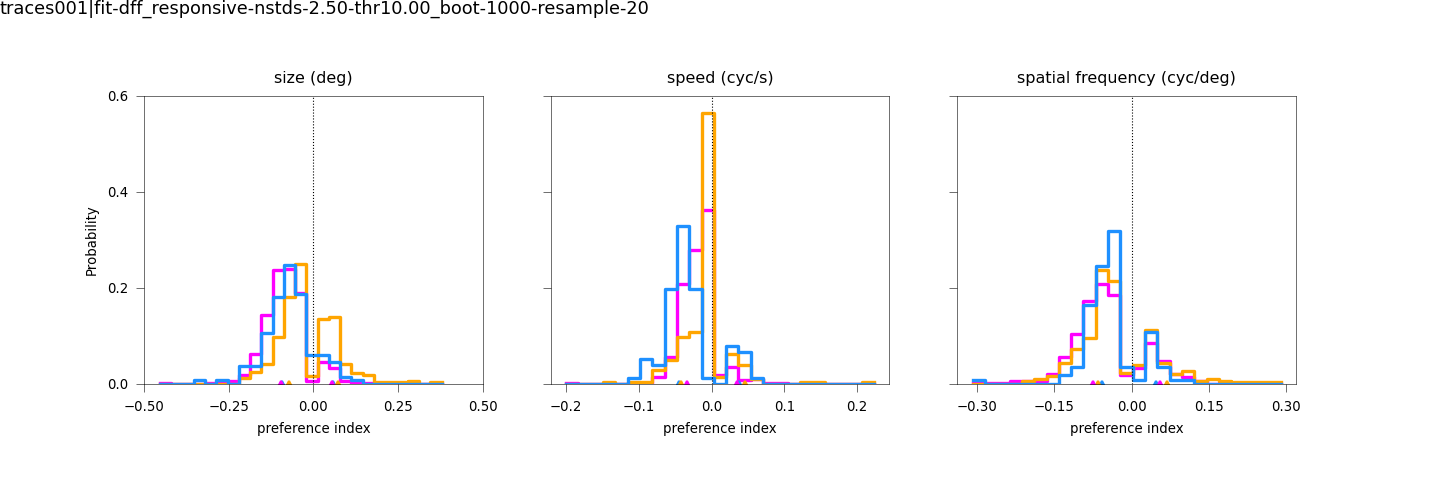

In [304]:
plot_type='stephist'
fig, axn = pl.subplots(1, len(paramnames), sharey=True, figsize=(9,3))
for ax, p in zip(axn.flat, paramnames):
    df_ = nonori_df[nonori_df['metric']==p].copy()
    sns.histplot(x='value', data=df_, 
                 hue='visual_area', palette=area_colors, ax=ax, bins=25,
                  stat='probability', common_norm=False, fill=False,
                element='step')#,
                 #multiple="stack")
    for va, vg in df_.groupby(['visual_area']):
        ax.plot(vg[vg['value']<0]['value'].mean(), -0.0, 
                marker='^', color=area_colors[va], markersize=3)
        ax.plot(vg[vg['value']>0]['value'].mean(), -0.0, marker='^', 
                color=area_colors[va], markersize=3)

    ax.axvline(x=0,color='k', lw=0.5, ls=':')
    ax.set_title(p)
    ax.legend_.remove()
    if p=='size':
        ax.set_title('size (deg)')
        ax.set_xticks(np.linspace(-0.5, 0.5, 5))
    elif p=='speed':
        ax.set_title('speed (cyc/s)')
        ax.set_xticks(np.linspace(-0.2, 0.2, 5))
    else:
        ax.set_title('spatial frequency (cyc/deg)')
        ax.set_xticks(np.linspace(-0.3, 0.3, 5))
    ax.set_ylim((0, 0.6))
    ax.set_yticks(np.linspace(0, 0.6, 4))
    ax.set_yticklabels([round(i, 1) for i in np.linspace(0, 0.6, 4)])
    ax.set_xlabel('preference index')
        
    #sns.despine(trim=True, offset=-2, left=False)
pl.subplots_adjust(bottom=0.2, left=0.1, top=0.8)
pplot.label_figure(fig, data_id)

figname = 'nonori_distns_%s_%s' % (plot_type, dset_str)
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))

In [269]:
nonori_counts = nonori_df[['visual_area', 'datakey', 'cell', 'metric']].drop_duplicates()\
                    .groupby(['metric', 'visual_area', 'datakey']).count().reset_index()
nonori_counts.index = ['%s_%s' % (va, dk) for (va, dk) \
                      in nonori_counts[['visual_area', 'datakey']].values]

In [271]:
nonori_counts[nonori_counts['metric']=='sf']

metric visual_area              datakey  cell
Li_20190522_JC089_fov1     sf          Li  20190522_JC089_fov1     4
Li_20190602_JC091_fov1     sf          Li  20190602_JC091_fov1    39
Li_20190612_JC099_fov1     sf          Li  20190612_JC099_fov1    17
Li_20190614_JC091_fov1     sf          Li  20190614_JC091_fov1    30
Li_20191018_JC113_fov1     sf          Li  20191018_JC113_fov1    20
Lm_20190512_JC083_fov1     sf          Lm  20190512_JC083_fov1    73
Lm_20190513_JC078_fov1     sf          Lm  20190513_JC078_fov1    83
Lm_20190525_JC084_fov1     sf          Lm  20190525_JC084_fov1    43
Lm_20190603_JC080_fov1     sf          Lm  20190603_JC080_fov1    62
Lm_20190618_JC097_fov1     sf          Lm  20190618_JC097_fov1    17
Lm_20190627_JC091_fov1     sf          Lm  20190627_JC091_fov1    24
V1_20190511_JC083_fov1     sf          V1  20190511_JC083_fov1    91
V1_20190522_JC084_fov1     sf          V1  20190522_JC084_fov1    96
V1_20190613_JC097_fov1     sf          V1  20190613_JC097_fov1    51
V1_20190616_JC097_fov1     sf          V1  20190616_JC097_fov1   106
V1_20190617_JC097_fov1     sf          V1  20190617_JC097_fov1    46
V1_20190622_JC085_fov1     sf          V1  20190622_JC085_fov1    94
V1_20191006_JC110_fov1     sf          V1  20191006_JC110_fov1    71

In [272]:
final_counts['sf_selective'] = nonori_counts[nonori_counts['metric']=='sf']['cell']

final_counts['size_selective'] = nonori_counts[nonori_counts['metric']=='size']['cell']

final_counts['speed_selective'] = nonori_counts[nonori_counts['metric']=='speed']['cell']

In [276]:
final_counts = final_counts.fillna(0)


In [279]:
for p in paramnames:
    final_counts['fraction_%s' % p] = final_counts['%s_selective' % p]/final_counts['visual']
    

In [ ]:
final_counts.to_csv (r'%s' % counts_outfile, index=False, header=True)
print(counts_outfile)

<IPython.core.display.Javascript object>


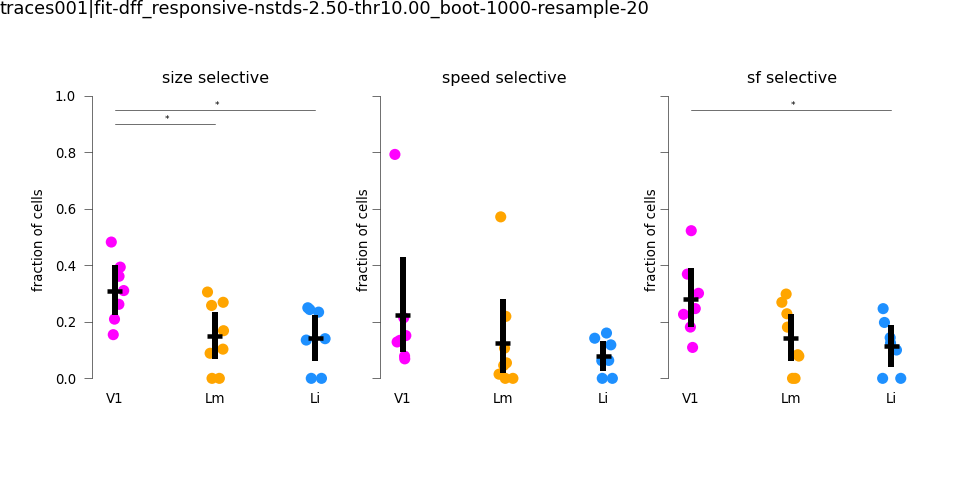

********* [fraction_size] Mann-Whitney U test(mc=fdr_bh) **********
   d1  d2  reject     p_val  U_val  n1  n2
0  V1  Lm    True  0.024092    9.0   7   8
1  V1  Li    True  0.024092    6.0   7   7
2  Lm  Li   False  0.385167   25.0   8   7
****************************
********* [fraction_speed] Mann-Whitney U test(mc=fdr_bh) **********
   d1  d2  reject     p_val  U_val  n1  n2
0  V1  Lm   False  0.088413   14.0   7   8
1  V1  Li   False  0.088413   11.0   7   7
2  Lm  Li   False  0.430476   26.0   8   7
****************************
********* [fraction_sf] Mann-Whitney U test(mc=fdr_bh) **********
   d1  d2  reject     p_val  U_val  n1  n2
0  V1  Lm   False  0.054445   12.0   7   8
1  V1  Li    True  0.044493    7.0   7   7
2  Lm  Li   False  0.385167   25.0   8   7
****************************
/n/coxfs01/julianarhee/aggregate-visual-areas/gratings-tuning/traces001-fit-dff_responsive-nstds-2.50-thr10.00_boot-1000-resample-20/aggregate_metrics fractioN_nonori_selective_drop_repeats


In [320]:
fig, axn = pl.subplots(1,len(paramnames), figsize=(6,3), sharey=True, sharex=True)
for ax, p in zip(axn.flat, paramnames):
    sns.stripplot(x='visual_area', y='fraction_%s' % p, data=final_counts, ax=ax,
        hue='visual_area', palette=area_colors, order=visual_areas ,zorder=-1)
    sns.pointplot(x='visual_area', y='fraction_%s' % p, data=final_counts, ax=ax,
        color='k', markers='_', scale=1, errwidht=0.5, order=visual_areas, 
                  join=False, zorder=10000)
    pplot.plot_mannwhitney(final_counts, metric='fraction_%s' % p, ax=ax,
                        multi_comp_test=multi_comp_test,
                        y_loc=0.9, offset=0.05, lw=0.25,fontsize=4)
    ax.legend_.remove()
    ax.tick_params(which='both', axis='x', size=0)
    ax.set_title("%s selective" % p)
    ax.set_xlabel('')
    ax.set_ylim([-0.02, 1])
    ax.set_yticks(np.linspace(0, 1, 6))
    sns.despine(bottom=True, trim=True, offset=2)
    ax.set_ylabel("fraction of cells")
pl.subplots_adjust(bottom=0.2, left=0.1, top=0.8, right=0.95) 
pplot.label_figure(fig, data_id)

figname = 'fractioN_nonori_selective_%s' % (dset_str)
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
print(curr_dst_dir, figname)

In [287]:
final_counts

visual_area              datakey  tuned  \
Li_20190314_JC070_fov1          Li  20190314_JC070_fov1     31   
Li_20190315_JC070_fov2          Li  20190315_JC070_fov2      6   
Li_20190522_JC089_fov1          Li  20190522_JC089_fov1      7   
Li_20190602_JC091_fov1          Li  20190602_JC091_fov1     59   
Li_20190612_JC099_fov1          Li  20190612_JC099_fov1     15   
Li_20190614_JC091_fov1          Li  20190614_JC091_fov1     39   
Li_20191018_JC113_fov1          Li  20191018_JC113_fov1     20   
Lm_20190306_JC061_fov2          Lm  20190306_JC061_fov2     66   
Lm_20190314_JC070_fov2          Lm  20190314_JC070_fov2     48   
Lm_20190512_JC083_fov1          Lm  20190512_JC083_fov1    107   
Lm_20190513_JC078_fov1          Lm  20190513_JC078_fov1    178   
Lm_20190525_JC084_fov1          Lm  20190525_JC084_fov1     58   
Lm_20190603_JC080_fov1          Lm  20190603_JC080_fov1     84   
Lm_20190618_JC097_fov1          Lm  20190618_JC097_fov1     28   
Lm_20190627_JC091_fov1          Lm  20190627_JC091_fov1     37   
V1_20190511_JC083_fov1          V1  20190511_JC083_fov1    132   
V1_20190522_JC084_fov1          V1  20190522_JC084_fov1    107   
V1_20190613_JC097_fov1          V1  20190613_JC097_fov1     65   
V1_20190616_JC097_fov1          V1  20190616_JC097_fov1    111   
V1_20190617_JC097_fov1          V1  20190617_JC097_fov1     74   
V1_20190622_JC085_fov1          V1  20190622_JC085_fov1     96   
V1_20191006_JC110_fov1          V1  20191006_JC110_fov1     77   

                        direction_selective  fraction_dsi  axis_selective  \
Li_20190314_JC070_fov1                   15      0.483871             1.0   
Li_20190315_JC070_fov2                    5      0.833333             0.0   
Li_20190522_JC089_fov1                    4      0.571429             1.0   
Li_20190602_JC091_fov1                   20      0.338983             1.0   
Li_20190612_JC099_fov1                    5      0.333333             0.0   
Li_20190614_JC091_fov1                   10      0.256410             2.0   
Li_20191018_JC113_fov1                    5      0.250000             1.0   
Lm_20190306_JC061_fov2                   24      0.363636             7.0   
Lm_20190314_JC070_fov2                    9      0.187500             4.0   
Lm_20190512_JC083_fov1                   10      0.093458             0.0   
Lm_20190513_JC078_fov1                  110      0.617978            42.0   
Lm_20190525_JC084_fov1                   24      0.413793            18.0   
Lm_20190603_JC080_fov1                   38      0.452381            16.0   
Lm_20190618_JC097_fov1                    6      0.214286            10.0   
Lm_20190627_JC091_fov1                   14      0.378378            10.0   
V1_20190511_JC083_fov1                   61      0.462121            36.0   
V1_20190522_JC084_fov1                   55      0.514019            37.0   
V1_20190613_JC097_fov1                   21      0.323077            19.0   
V1_20190616_JC097_fov1                   28      0.252252            23.0   
V1_20190617_JC097_fov1                   26      0.351351            14.0   
V1_20190622_JC085_fov1                   32      0.333333            32.0   
V1_20191006_JC110_fov1                   16      0.207792             7.0   

                        fraction_asi  visual  fraction_tuned  pass_gof  \
Li_20190314_JC070_fov1      0.032258     137        0.226277        16   
Li_20190315_JC070_fov2      0.000000     102        0.058824         5   
Li_20190522_JC089_fov1      0.142857      32        0.218750         5   
Li_20190602_JC091_fov1      0.016949     197        0.299492        20   
Li_20190612_JC099_fov1      0.000000     118        0.127119         5   
Li_20190614_JC091_fov1      0.051282     299        0.130435        12   
Li_20191018_JC113_fov1      0.050000      81        0.246914         6   
Lm_20190306_JC061_fov2      0.106061     219        0.301370        31   
Lm_20190314_JC070_fov2      0.083333     301        0.159468      

#### Test nonori w/ single FOV

In [193]:
va='V1'
dk ='20190617_JC097_fov1'
# va='Li'
# dk ='20190602_JC091_fov1'
rdf = NDATA[(NDATA.visual_area==va) & (NDATA.datakey==dk)].copy()
sdf = p3.get_stimuli(dk, 'gratings')
# Add stimulus info
for p in paramnames:
    rdf[p] = sdf.loc[rdf['config']][p].values

In [129]:
# Do bootstrap
# R = rdf.groupby('cell').apply(bootstrap_and_evaluate_nonori, sdf=sdf)
# R.head()

sf  size  speed  cell
cell                        
0     0.0   0.0    0.0   0.0
1     0.0   0.0    0.0   1.0
2     1.0   1.0    1.0   2.0
3     0.0   1.0    0.0   3.0
5     0.0   0.0    0.0   5.0

In [131]:
R.loc[rid]

sf         1.0
size       0.0
speed      1.0
cell     155.0
Name: 155, dtype: float64

In [232]:
# x_=[]
# for param in paramnames:
#     ixs0 = rdf.groupby(['cell']).apply(calculate_nonori_index, param=param)
#     ixs_ = pd.DataFrame(ixs0, columns=['value'])
#     ixs_['metric'] = param
#     ixs_['cell'] = ixs_.index
#     x_.append(ixs_.reset_index(drop=True))
# curr_ixs = pd.concat(x_, axis=0)


In [224]:
ixs_ = rdf.groupby(['cell']).apply(calculate_nonori_index, param='size')

In [228]:
rid=280
rd = rdf[rdf['cell']==rid].copy()

In [230]:
param='size'
vmin = rd['response'].min()
if vmin < 0:
    rd['response'] = rd['response'] - vmin
lo, hi = rd[param].unique().min(), rd[param].unique().max()
v1 = rd[rd[param]==lo]['response'].mean() 
v2 = rd[rd[param]==hi]['response'].mean() 
ix = (v2-v1)/(v1+v2) 
print(param, ix)

size -0.09436637992575322


In [177]:
rid = 280 #155
rd = rdf[rdf['cell']==rid].copy()
trial_vals = get_trial_df(rd)
true_ = index_from_samples(trial_vals, sdf=sdf)


In [178]:
iterd = bootstrap_index_calculation(rd, sdf=sdf, 
                        n_bootstrap_iters=n_bootstrap_iters)
reject_ = check_null(iterd, alpha=alpha)
reject_['cell'] = float(rd['cell'].unique())

alpha=95
sf_lo, sz_lo, sp_lo = np.percentile(iterd, (100-alpha)/2, axis=0)
sf_hi, sz_hi, sp_hi = np.percentile(iterd, alpha+((100-alpha)/2), axis=0)
param_cis = [(sf_lo, sf_hi), (sz_lo, sz_hi), (sp_lo, sp_hi)]


<IPython.core.display.Javascript object>


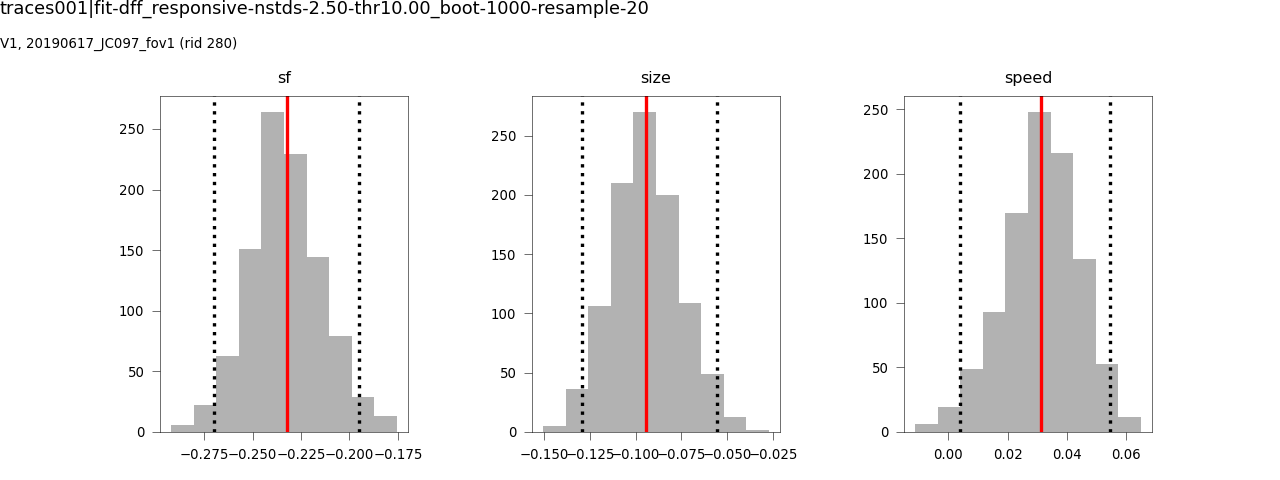

/n/coxfs01/julianarhee/aggregate-visual-areas/gratings-tuning/traces001-fit-dff_responsive-nstds-2.50-thr10.00_boot-1000-resample-20/aggregate_metrics examples nonori_V1_20190617_JC097_fov1_rid280


In [179]:

pvals=[]
fig, axes = pl.subplots(1, 3, figsize=(8, 3))
for ax, param, ci_ in zip(axes.flat, ['sf', 'size', 'speed'], param_cis):
    iter_vs = iterd[param]
    ax.hist(iter_vs, color='k', alpha=0.3)
    reject_null = ~(ci_[0] < 0 < ci_[1])
    #ci_upper2 = np.percentile(ordered, alpha)
    true_v = float(true_[param])
    if reject_null:
        lcolor ='r'
    else:
        lcolor = 'k'
    ax.axvline(x=ci_[0], color='k', linestyle=':')
    ax.axvline(x=ci_[1], color='k', linestyle=':')
    ax.axvline(x=true_v, color=lcolor)
    ax.set_title(param)
    nonsig = ci_lower <= true_v<= ci_upper
    pvals.append(not nonsig)
fig.text(0, 0.9, '%s, %s (rid %i)' % (va, dk, rid))
pplot.label_figure(fig, data_id)
pl.subplots_adjust(wspace=0.5, hspace=0.8, top=0.8, bottom=0.1)

figname = 'nonori_%s_%s_rid%i' % (va, dk, rid)
pl.savefig(os.path.join(curr_dst_dir, 'examples', '%s.svg' % figname))
print(curr_dst_dir, 'examples', figname)

In [181]:
true_

sf      -0.232310
size    -0.094366
speed    0.031167
dtype: float64

In [182]:
r_.loc[rid]

size    -0.094366
speed    0.031167
sf      -0.232310
Name: 280, dtype: float64

In [109]:
sf_lo, sz_lo, sp_lo = np.percentile(testd, (100-alpha)/2, axis=0)
sf_hi, sz_hi, sp_hi = np.percentile(testd, alpha+((100-alpha)/2), axis=0)
print(sf_lo, sz_lo, sp_lo)

-0.07162004857895753 -0.011886071667971395 -0.02623979624770266


In [101]:
sf_hi, sz_hi, sp_hi = np.percentile(testd, alpha+((100-alpha)/2), axis=0)

array([-0.05118127,  0.01001683, -0.00581061])

In [106]:
reject_null = (ci_lower < 0 < ci_upper)
reject_null

False

In [96]:
R = rdf.groupby(['cell']).apply(bootstrap_index_calculation, 
                            sdf=sdf, n_bootstrap_iters=100)

In [354]:
len(reliable_rois[reliable_rois==True].index.tolist())


60

In [355]:
len(rdf['cell'].unique())

65

In [332]:
rid = 0 #155 #280 #262 # Pref. sf=0.1
rd = rdf[rdf['cell']==rid].copy()

In [333]:
iters = bootstrap_nonori(rd)
is_r = is_reliable_or_no(rd, iters)
print(is_r)
# if is_r:
#     reliable_rois.append(rid)
        
        
# reliabe_=[]
# for (sz, sf, sp), g in rd.groupby(['size', 'sf', 'speed']):
#     iter_vs = iters[(iters['size']==sz) & (iters['sf']==sf) & (iters['speed']==sp)]
#     ordered = sorted(iter_vs['response'])
#     ci_lower = np.percentile(ordered, (100-alpha)/2)
#     ci_upper = np.percentile(ordered, alpha+((100-alpha)/2))
#     true_v =float(g['response'].mean())
#     r_val = ci_lower>0 and (ci_lower<true_v<ci_upper)
#     reliable_.append(r_val)
# if any(reliable_):
#     reliable_rois.append(rid)

True


In [283]:
figname = 'nonori_%s_%s_rid%i' % (va, dk, rid)
pl.savefig(os.path.join(curr_dst_dir, 'examples', '%s.svg' % figname))
print(curr_dst_dir, 'examples', figname)

'/n/coxfs01/julianarhee/aggregate-visual-areas/gratings-tuning/traces001-fit-dff_responsive-nstds-2.50-thr10.00_boot-1000-resample-20/aggregate_metrics'

In [325]:
p_ixs={}
for p in paramnames:
    lo, hi = rd[p].unique().min(), rd[p].unique().max()
    v1 = rd[rd[p]==lo]['response'].mean() 
    v2 = rd[rd[p]==hi]['response'].mean() 
    ix = (v1-v2)/(v1+v2) # +1 smaller preferred, -1 bigger val preferred
    p_ixs.update({p: ix})
pd.DataFrame(p_ixs, index=[rid])

size     speed        sf
280  0.374773 -0.123779  0.922612

In [317]:
(v1-v2)/(v1+v2)

0.9226119166018091

In [318]:
rid

280